#Quantum Portfolio Optimization Project with Time Series Forecasting
Created by Zain Mughal
<br>
<br>

###Introduction
This is a Quantum Finance Machine Learning project that aims to explore the application of quantum computing in the field of finance. 

<br>

Part I focuses on portfolio optimization, a critical aspect of investment management. The idea is to optimize a stock portfolio using classical and quantum algorithms using historical stock data from a selection of companies. This implementation collects historical stock price data, imposes sector constraints for diversification, and rebalances the portfolio using classical optimization (NumPy Minimum Eigen Solver), Quantum optimization using VQE, and Quantum optimization using QAOA. 

<br>

Part II focuses on Time Series Forecasting. Time series forecasting is a technique used to predict future values of a time-dependent data series based on historical observations. A LSTM (Long Short-Term Memory) model is used to predict future stock returns. LSTM is a type of recurrent neural network (RNN) that is well-suited for time series forecasting because it can learn long-term dependencies in the data. The LSTM model is trained on historical stock prices and used to forecast future returns, which are then incorporated into the portfolio optimization problems. By incorporating the LSTM's predictions into the optimization process, the project aims to improve the overall performance of the optimization algorithms. This is done by taking into account not only historical data but also predictions of future returns, which should help the optimization algorithms make better-informed decisions regarding asset allocation.

<br>

In summary, this project combines classical and quantum optimization methods with LSTM time series forecasting to improve the performance of portfolio optimization. By incorporating predicted future stock returns into the optimization process, the project seeks to enhance the decision-making process for asset allocation and potentially achieve better returns and reduced risk.

<br>

###Methodology

#####Part 1: Quantum Portfolio Optimization
1. Data Collection and Preprocessing: Collected historical stock prices for a set of stocks using Yahoo Finance API. Divided data into multiple rebalancing periods and fetched industry sector information for each stock.

2. Portfolio Optimization: For each rebalancing period, calculated the daily returns, expected returns, and covariance matrix. Formulated the portfolio optimization problem using the expected returns, covariance matrix, risk factor, and budget, while imposing sector constraints to ensure diversification across different industries. Applied classical NumPyMinimumEigensolver, VQE, and QAOA algorithms to solve the portfolio optimization problem for each rebalancing period. Obtained the optimized portfolio allocations and computed the portfolio returns for each algorithm.

3. Performance Evaluation: Calculated metrics such as Cumulative Return, Maximum Drawdown, Sharpe Ratio, and more, for each algorithm. Compared their performance visually and numerically to determine which method yielded the best results.

#####Part 2: Time Series Forecasting
1. Loading and Processing Data for Time Series: Loaded the historical stock prices and processed data for Time Series Forecasting by calculating the percentage change. Scaled the data using MinMaxScaler and created rolling windows with a window period of 60 days. Split the data into training and testing sets.

2. Exploratory Data Analysis: Analyzed the stock price data to identify trends, patterns, and any seasonality that could be useful for the LSTM model.

3. LSTM Model Architecture, Hyperparameter Tuning, Training and Testing: Designed a Bidirectional LSTM model with dropout layers and L1L2 regularization to prevent overfitting. Compiled and trained the model using the Adam optimizer, then evaluated its performance.

4. Future Stock Prediction Portfolio Stock Allocation: Used the LSTM model to predict future stock returns, which were then incorporated into the portfolio optimization problem. Adjusted the stock allocations based on the predicted returns to improve the overall performance of the portfolio.

5. Portfolio Performance Evaluation: Calculated various metrics such as actual returns, LSTM predicted returns, improvement in ROI, and Mean Absolute Error (MAE) for each rebalancing period. Visualized the actual returns vs. LSTM predicted returns and improvement in ROI vs. MAE.

6. Final Metrics Comparison: Calculated the total portfolio return, maximum drawdown, and Sharpe Ratio for each algorithm (Classical, VQE, and QAOA). Compared the metrics to evaluate the performance of each algorithm in the portfolio optimization problem.

References:

1. https://qiskit.org/documentation/finance/tutorials/01_portfolio_optimization.html

2. https://qiskit.org/documentation/finance/tutorials/11_time_series.html

3. https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

4. https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf

5. https://www.tensorflow.org/tutorials/structured_data/time_series

6. https://medium.com/@pierre.beaujuge/multivariate-time-series-forecasting-with-a-bidirectional-lstm-building-a-model-geared-to-4f020a160636

7. https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f

In [1]:
"""
Function to print results, given from Ref 1. 
Needed for both Part I and II. 
"""

def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = problem.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

#**Part I - Quantum Portfolio Optimization**

In [2]:
#Import all Neccessary Libraries for Part 1 (NOTE - most of these are needed for Part II)
!pip install qiskit
!pip install yfinance
!pip install qiskit[finance]
!pip install qiskit[optimization]
!pip install yahooquery
!pip install qiskit_machine_learning
!pip install tensorflow

import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from yahooquery import Ticker
from datetime import datetime
from qiskit import Aer
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE, VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_aer.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit.result import QuasiDistribution
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 4.1 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.42.1-py3-no

##Data Collection and Processing

Yahoo Finance API is used to collect historical stock prices for the selected tickers

####Explanations of Processing 

1. Sector constraints are limitations imposed on the amount of investment allocated to each industry sector within a portfolio. These constraints help to promote diversification and reduce the portfolio's exposure to industry-specific risks. The maximum allocation refers to the maximum percentage of the portfolio that can be invested in a single industry sector. By setting a maximum allocation, investors can ensure that their portfolio remains well-diversified and not overly concentrated in any one industry.


2. Industry sector information is used to group stocks according to their primary business activities. This information is essential for imposing sector constraints in the portfolio optimization process, which ensures that the portfolio is diversified across different industries. By diversifying across industries, investors can reduce the impact of industry-specific risks on their portfolio's performance.


3. Diversification is a risk management strategy that involves investing in a variety of assets or sectors to reduce the overall risk associated with a portfolio. The idea is that different assets or sectors may perform differently under various market conditions, and by diversifying, the negative performance of some assets can be offset by the positive performance of others. This helps to stabilize the portfolio's returns and reduce its overall volatility.


4. Portfolio rebalancing is the process of periodically adjusting the asset allocations in a portfolio to maintain the desired level of risk and return. Rebalancing periods refer to the time intervals at which the portfolio is adjusted, while rebalancing intervals refer to the frequency at which the adjustments occur (e.g., monthly, quarterly, or annually). Rebalancing is important because it helps to ensure that the portfolio remains aligned with the investor's risk tolerance and investment objectives. It also helps to systematically capture gains from well-performing assets and reinvest them in underperforming assets, which can contribute to better long-term performance.



In [3]:
tickers = ["AAPL", "GOOGL", "TSLA", "IBM", "MSFT", "AMZN", "NVDA", "ADBE", "NFLX", "META"]
start_date = datetime(2015, 1, 1)
end_date = datetime(2022, 12, 31)
num_assets = len(tickers)

# Instantiate the YahooDataProvider with the start and end dates
provider = YahooDataProvider(tickers=tickers, start=start_date, end=end_date)

# Load the historical data
provider.run()

# Fetch industry sector information for the tickers
sectors = {}
for ticker in tickers:
    stock_info = Ticker(ticker).asset_profile[ticker]
    sectors[ticker] = stock_info['sector']

# Calculate the sector constraints
#Ffetch industry sector information for each ticker and set up sector constraints to ensure diversification.
#For example, this sets a maximum allocation per sector to 50%:
max_sector_allocation = 0.5  
sector_constraints = {}
for sector in set(sectors.values()):
    sector_constraints[sector] = max_sector_allocation

# Rebalancing interval - Divide the historical data into multiple rebalancing periods of 90 days each:
rebalancing_interval = 90

# Initialize the portfolio allocation
portfolio_allocation = np.zeros(num_assets)

# Convert the historical data to a DataFrame
historical_data = pd.DataFrame(provider._data).T
historical_data.index = pd.to_datetime(historical_data.index)

# Calculates the number of rebalancing periods
#num_periods = (historical_data.index[-1] - historical_data.index[0]).days // rebalancing_interval #Will use this definition in Part 2
num_periods = 10


#Characteristics for Portfolio Optimization 
risk_factor = 0.5
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

##Portfolio Optimization

Portfolio optimization involves finding the optimal asset allocations that maximize the expected return for a given level of risk or minimize the risk for a given level of expected return. This process allows investors to construct a portfolio that is tailored to their specific risk tolerance and investment objectives.


<br>
<br>

Definition: 
1. Covariance matrix: The covariance matrix is a measure of how the returns of different assets in a portfolio move together. It is used in portfolio optimization to quantify the degree of correlation between assets, which is an important factor when determining the overall risk and return of a portfolio. A covariance matrix helps investors to understand the relationships between assets and make informed decisions about diversification and asset allocation.

####Classical Optimization using NumPy Minimum Eigen Solver 

The NumPy Minimum Eigen Solver is used to find the minimum eigenvalue and the corresponding eigenvector of the stock returns covariance matrix, which helps determine the optimal asset allocation

In [4]:
classical_returns_list= []
# Loop through the rebalancing periods
for period in range(num_periods):
    start_date = historical_data.index[0] + pd.DateOffset(days=period * rebalancing_interval)
    end_date = start_date + pd.DateOffset(days=rebalancing_interval)
    data_slice = historical_data.loc[start_date:end_date]

    # Calculates the covariance matrix and expected returns for the current slice
    sigma_slice = data_slice.cov().to_numpy()
    mu_slice = data_slice.mean().to_numpy()
    

    # Updates the portfolio optimization problem with the new expected returns and covariance matrix
    problem = PortfolioOptimization(expected_returns=mu_slice, covariances=sigma_slice, risk_factor=risk_factor, budget=budget)
    qp = problem.to_quadratic_program()
    

    # Adds industry diversification constraints to the quadratic program for the current slice
    for sector, max_allocation in sector_constraints.items():
        involved_stocks = [i for i, ticker in enumerate(tickers) if sectors[ticker] == sector]
        qp.linear_constraint(linear={i: 1 for i in involved_stocks}, sense="<=", rhs=max_allocation, name=f"diversify_{sector}")

    # Solves the problem for the current slice using classical NumPyMinimumEigensolver
    numpy_solver = NumPyMinimumEigensolver()
    classical_result = MinimumEigenOptimizer(numpy_solver).solve(qp)
    print(f"Rebalancing period {period + 1}:")
    print_result(classical_result)
    classical_returns_list.append(classical_result.fval)

# Calculates portfolio returns
classical_period_indices = range(90, len(classical_returns_list)*rebalancing_interval + 1, 90)
portfolio_returns_classical = pd.Series(classical_returns_list, index=historical_data.index[classical_period_indices])

The value could be too small. If so, set the penalty coefficient manually.
The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 1:
Optimal: selection [0. 0. 1. 1. 0. 0. 0. 1. 0. 1.], value -249.9233

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 0 0 0 1 0 1]	-249.9233		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 2:
Optimal: selection [0. 0. 0. 1. 0. 1. 0. 1. 0. 1.], value -277.7791

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 1 0 1 0 1]	-277.7791		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 3:
Optimal: selection [0. 0. 0. 1. 0. 1. 0. 1. 0. 1.], value -257.5863

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 1 0 1 0 1]	-257.5863		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 4:
Optimal: selection [0. 0. 1. 1. 0. 0. 0. 1. 0. 1.], value -279.4856

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 0 0 0 1 0 1]	-279.4856		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 5:
Optimal: selection [0. 0. 0. 1. 0. 1. 0. 1. 0. 1.], value -210.5760

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 1 0 1 0 1]	-210.5760		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 6:
Optimal: selection [0. 0. 0. 1. 0. 1. 0. 0. 1. 1.], value -321.0212

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 1 0 0 1 1]	-321.0212		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 7:
Optimal: selection [0. 0. 0. 1. 0. 1. 0. 0. 1. 1.], value -314.9531

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 1 0 0 1 1]	-314.9531		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 8:
Optimal: selection [0. 0. 0. 1. 0. 1. 0. 1. 0. 1.], value -359.4223

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 1 0 1 0 1]	-359.4223		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 9:
Optimal: selection [0. 0. 0. 1. 1. 1. 0. 0. 1. 0.], value -287.8998

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1 1 0 0 1 0]	-287.8998		1.0000
Rebalancing period 10:
Optimal: selection [0. 0. 0. 1. 0. 1. 0. 1. 0. 1.], value -420.4857

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 1 0 1 0 1]	-420.4857		1.0000


In the context of this optimization problem, the value being negative indicates that the portfolio generated by the optimization algorithm is expected to have a lower cost or risk than the initial portfolio. In other words, it is expected to perform better than the initial portfolio.


The output shows the optimal stock selection and the corresponding portfolio value for each rebalancing period. For each period, the optimization process finds the best allocation of stocks to minimize risk and maximize returns, considering the specified constraints.

For example, if the first output line is:

Rebalancing period 1: Optimal: selection [0. 0. 0. 1. 0. 1. 0. 1. 0. 1.], value -262.1596

This tells you that, in the first rebalancing period, the optimal selection of stocks is represented by the array [0. 0. 0. 1. 0. 1. 0. 1. 0. 1.]. In this array, each element corresponds to a stock in the portfolio: a 1 indicates that the stock should be included in the portfolio, while a 0 indicates that it should not be included. The value -262.1596 represents the optimized portfolio value (note that this is a negative value, as the optimization problem is formulated as a minimization problem). The higher the magnitude of the negative value, the better the portfolio performance.

The "Full result" section shows the selection, value, and probability for each optimal solution found by the solver. In this case, it seems that there is a single solution for each rebalancing period with a probability of 1.0000, indicating that the solver is confident in the optimal solution found.

These results help an investor understand which stocks to include in their portfolio for each rebalancing period to achieve optimal performance based on the historical data and given constraints (risk, return, and industry diversification)

####Quantum Optimization using VQE (Variational Quantum Eigensolver)

This method uses a quantum algorithm to find the ground state energy of a given Hamiltonian, which represents the risk of the portfolio in this case. The eigenvector corresponding to the ground state energy provides the optimal asset allocation

In [5]:
vqe_returns_list = []
# Loop through the rebalancing periods
for period in range(num_periods):
    start_date = historical_data.index[0] + pd.DateOffset(days=period * rebalancing_interval)
    end_date = start_date + pd.DateOffset(days=rebalancing_interval)
    data_slice = historical_data.loc[start_date:end_date]

    # Calculate the covariance matrix and expected returns for the current slice
    sigma_slice = data_slice.cov().to_numpy()
    mu_slice = data_slice.mean().to_numpy()

    # Update the portfolio optimization problem with the new expected returns and covariance matrix
    problem = PortfolioOptimization(expected_returns=mu_slice, covariances=sigma_slice, risk_factor=risk_factor, budget=budget)
    qp = problem.to_quadratic_program()
    

    # Add industry diversification constraints to the quadratic program for the current slice
    for sector, max_allocation in sector_constraints.items():
        involved_stocks = [i for i, ticker in enumerate(tickers) if sectors[ticker] == sector]
        qp.linear_constraint(linear={i: 1 for i in involved_stocks}, sense="<=", rhs=max_allocation, name=f"diversify_{sector}")

    
    

    #VQE
    algorithm_globals.random_seed = 1234
    cobyla = COBYLA()
    cobyla.set_options(maxiter=500)
    ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
    vqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
    vqe_result = MinimumEigenOptimizer(vqe_mes).solve(qp)
    print(f"Rebalancing period {period + 1} using VQE:")
    print_result(vqe_result)
    vqe_returns_list.append(vqe_result.fval)

# Calculate portfolio returns
vqe_period_indices = range(90, len(vqe_returns_list)*rebalancing_interval + 1, 90)
portfolio_returns_vqe = pd.Series(vqe_returns_list, index=historical_data.index[vqe_period_indices])

The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 1 using VQE:
Optimal: selection [0. 0. 1. 1. 1. 0. 0. 1. 0. 1.], value -288.9922

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 1 0 0 0 0 0 0]	-142.0439		0.1348
[0 0 1 1 0 0 1 0 0 0]	-121.6175		0.1182
[0 1 1 1 0 0 0 0 0 1]	-211.0993		0.0498
[0 0 1 1 0 0 1 0 0 1]	-192.3534		0.0479
[0 1 0 1 0 0 1 0 0 0]	-132.7297		0.0361
[0 0 1 0 1 0 0 0 1 0]	-90.9709		0.0312
[0 1 1 0 1 0 0 0 1 0]	-113.1691		0.0254
[1 0 0 0 1 0 1 0 1 0]	-98.9301		0.0244
[0 0 1 0 1 0 1 0 1 0]	-94.9479		0.0244
[0 1 1 1 1 0 0 0 0 0]	-179.7270		0.0234
[0 0 1 0 0 0 1 0 1 0]	-52.1271		0.0225
[1 0 1 0 1 0 0 0 1 0]	-108.2589		0.0225
[0 0 1 1 1 0 0 0 0 0]	-153.6548		0.0195
[0 1 1 1 1 0 1 0 0 0]	-184.2269		0.0186
[1 0 0 0 0 0 1 0 1 0]	-54.1181		0.0186
[1 0 0 0 1 0 0 0 1 0]	-95.5056		0.0166
[0 0 1 0 0 0 1 0 0 0]	-18.4140		0.0117
[0 1 1 0 0 0 0 0 1 0]	-69.5123		0.0117
[0 1 0 0 0 0 1 0 1 0]	-59.8635		0.0107
[1 1 1 0 0 0 1 

The value could be too small. If so, set the penalty coefficient manually.


[1 0 0 1 0 0 1 0 0 1]	-197.4318		0.0010
[1 1 1 1 1 0 1 0 1 0]	-224.4174		0.0010
[0 1 1 1 0 1 1 1 0 0]	-215.8629		0.0010
[1 1 1 0 0 0 1 0 1 1]	-152.5562		0.0010
[1 1 1 1 0 0 0 0 0 1]	-229.3154		0.0010
[0 1 1 0 0 1 1 0 0 1]	-129.2708		0.0010
[0 1 1 0 1 0 0 1 0 0]	-146.0951		0.0010
[0 0 0 1 0 0 0 0 0 1]	-174.0897		0.0010
[0 1 0 1 0 0 0 1 0 0]	-191.1465		0.0010
Rebalancing period 2 using VQE:
Optimal: selection [0. 1. 0. 1. 0. 1. 1. 1. 0. 1.], value -309.5905

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 0 1 1 0 0 0]	-159.8439		0.1143
[1 1 0 1 0 1 0 0 0 0]	-182.1673		0.0752
[1 1 0 1 0 1 1 0 0 0]	-187.5122		0.0430
[0 1 1 1 0 1 0 0 0 0]	-166.2841		0.0381
[1 1 0 0 0 1 0 0 1 0]	-97.9333		0.0312
[0 1 0 0 0 1 1 0 1 0]	-77.1001		0.0283
[1 0 1 1 0 1 0 0 0 0]	-167.1944		0.0254
[0 1 1 0 0 1 0 0 0 0]	-61.1486		0.0225
[1 1 0 0 0 0 1 0 0 0]	-61.3259		0.0205
[0 0 1 1 0 1 0 0 0 0]	-139.6199		0.0186
[1 1 0 0 0

The value could be too small. If so, set the penalty coefficient manually.


[1 1 1 1 1 0 1 0 0 0]	-212.1430		0.0010
[0 1 0 0 0 1 0 0 0 1]	-125.7149		0.0010
[0 1 0 0 1 1 0 1 0 0]	-154.0940		0.0010
[0 1 1 0 0 1 1 1 1 1]	-198.4076		0.0010
[0 1 0 0 1 1 0 0 1 1]	-168.7332		0.0010
[1 1 1 0 0 0 1 0 0 0]	-76.0587		0.0010
[0 1 1 0 1 0 1 0 1 0]	-90.8111		0.0010
[0 1 0 1 0 1 1 1 1 0]	-223.7749		0.0010
[1 0 0 0 0 1 1 1 1 0]	-132.1628		0.0010
[0 0 1 1 1 0 1 0 0 0]	-158.5337		0.0010
[1 0 1 0 0 0 0 0 0 1]	-121.2650		0.0010
[0 1 1 1 0 1 0 0 1 0]	-164.1173		0.0010
[1 1 1 0 1 1 0 0 1 1]	-193.1845		0.0010
[0 1 0 1 0 1 0 0 0 1]	-236.2913		0.0010
Rebalancing period 3 using VQE:
Optimal: selection [0. 1. 1. 1. 1. 1. 0. 0. 0. 1.], value -256.4077

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 1 1 0 1 0]	-76.2919		0.2422
[0 1 1 1 0 0 0 0 0 0]	-135.3335		0.1602
[0 1 0 1 0 1 0 0 0 0]	-146.9411		0.1475
[0 0 1 0 0 1 1 0 1 0]	-94.3335		0.1016
[1 1 1 1 0 0 0 0 0 0]	-152.9340		0.0635
[0 1 1 1 0

The value could be too small. If so, set the penalty coefficient manually.


[0 0 1 0 0 1 0 0 1 0]	-90.0749		0.0010
[0 1 1 1 1 1 0 0 0 1]	-256.4077		0.0010
[1 1 0 1 1 0 0 0 0 0]	-171.4668		0.0010
[0 1 0 1 0 1 1 0 1 0]	-175.3755		0.0010
[1 0 1 0 0 0 0 0 1 0]	-98.9460		0.0010
[0 0 0 1 1 1 1 0 1 1]	-234.6733		0.0010
[1 1 1 1 0 1 0 1 0 0]	-246.0161		0.0010
[0 1 1 1 0 1 0 0 1 0]	-185.1143		0.0010
[0 0 0 0 0 0 1 1 1 0]	-125.3827		0.0010
Rebalancing period 4 using VQE:
Optimal: selection [1. 0. 1. 1. 1. 0. 0. 1. 0. 1.], value -321.1106

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 1 0 0 1 0 0 0]	-140.5380		0.0879
[0 1 0 0 1 1 0 0 0 0]	-80.1657		0.0527
[0 0 0 1 0 0 1 0 0 0]	-99.6424		0.0400
[0 1 0 1 0 1 0 0 0 0]	-158.7001		0.0400
[0 1 1 1 0 0 1 0 0 0]	-152.0751		0.0381
[0 0 1 1 0 1 1 0 0 0]	-146.6208		0.0342
[0 1 1 1 0 0 0 0 0 0]	-144.9119		0.0312
[0 0 0 0 1 0 1 0 0 0]	-45.5526		0.0293
[0 1 1 1 0 1 0 0 0 0]	-173.4588		0.0283
[1 0 1 0 1 0 1 0 0 0]	-85.1028		0.0273
[0 0 1 1 0 0

The value could be too small. If so, set the penalty coefficient manually.


[1 0 1 0 0 0 0 0 0 0]	-40.5842		0.0010
[0 1 1 1 0 0 0 1 0 0]	-228.5392		0.0010
[1 0 0 0 0 0 1 0 1 0]	-99.0997		0.0010
[0 1 0 0 0 1 0 1 0 0]	-122.1507		0.0010
[0 1 1 0 1 0 0 0 0 0]	-83.1799		0.0010
[0 1 0 1 1 0 1 0 0 0]	-176.8693		0.0010
[0 0 1 1 0 0 0 1 0 0]	-196.2299		0.0010
[0 1 1 0 0 1 1 0 0 0]	-75.0381		0.0010
[1 1 0 1 0 1 0 0 0 1]	-253.8174		0.0010
[1 1 1 1 1 1 0 0 1 0]	-256.4779		0.0010
[1 0 1 1 1 1 1 0 0 1]	-271.1209		0.0010
[0 1 1 0 0 0 1 0 1 0]	-107.8043		0.0010
[1 0 1 1 0 1 1 0 0 0]	-172.1323		0.0010
Rebalancing period 5 using VQE:
Optimal: selection [0. 1. 0. 1. 1. 1. 0. 0. 1. 1.], value -248.0275

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1 0 1 0 1 0]	-95.0553		0.0762
[0 0 1 0 1 0 1 0 0 1]	-139.9719		0.0703
[0 0 1 0 1 0 0 0 0 0]	-55.7142		0.0664
[0 0 1 0 0 0 1 0 0 0]	-18.1604		0.0596
[0 0 1 0 1 0 0 0 1 0]	-91.9385		0.0410
[0 0 1 0 1 0 0 0 1 1]	-185.8111		0.0332
[0 0 1 0 0 0 1

The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 6 using VQE:
Optimal: selection [1. 1. 0. 1. 0. 1. 1. 0. 1. 1.], value -378.9003

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 0 1 0 0 0 0 0]	-109.1198		0.0742
[0 0 1 1 0 0 1 0 0 1]	-235.8931		0.0703
[1 1 0 0 1 0 0 0 1 0]	-151.3106		0.0654
[0 0 0 1 0 0 1 0 0 1]	-217.3057		0.0566
[0 1 1 1 0 0 1 0 0 1]	-273.1599		0.0488
[0 0 0 1 0 0 1 0 0 0]	-109.7166		0.0400
[1 1 1 0 1 0 0 0 1 0]	-157.7205		0.0391
[1 1 0 0 1 0 0 0 0 0]	-98.1425		0.0342
[0 0 1 1 0 0 0 0 0 0]	-117.6747		0.0264
[1 1 0 0 0 0 0 0 1 0]	-119.2832		0.0264
[0 1 1 1 0 0 0 0 0 1]	-265.7252		0.0254
[0 1 1 1 0 0 1 0 0 0]	-161.5853		0.0225
[0 0 0 1 0 1 0 0 0 1]	-233.3197		0.0205
[1 0 0 0 1 1 0 0 1 0]	-167.7275		0.0195
[0 0 1 1 0 0 0 0 0 1]	-229.0575		0.0176
[0 0 1 1 0 0 1 0 0 0]	-125.7708		0.0166
[1 1 1 0 1 0 1 0 0 0]	-121.2558		0.0156
[1 1 1 0 0 0 0 0 0 0]	-69.1611		0.0146
[0 1 1 1 0 0 0 0 0 0]	-152.8900		0.0127
[1 0 0 0

The value could be too small. If so, set the penalty coefficient manually.


[1 0 1 0 1 0 0 1 0 0]	-172.6565		0.0010
[0 0 1 1 0 0 1 1 0 1]	-322.4416		0.0010
[0 0 1 1 0 1 0 0 0 0]	-147.5872		0.0010
[0 1 0 1 0 0 1 0 1 0]	-214.0216		0.0010
[0 1 0 1 0 1 0 0 0 0]	-167.8697		0.0010
[0 0 1 1 1 0 0 0 0 0]	-161.5692		0.0010
[0 0 0 1 1 1 0 0 0 1]	-284.0247		0.0010
[1 1 1 1 1 0 1 0 0 0]	-221.9287		0.0010
[1 0 1 0 1 1 0 0 1 0]	-177.3492		0.0010
[1 1 1 0 0 0 1 1 0 0]	-173.8102		0.0010
[1 1 1 0 0 1 1 0 1 0]	-181.5420		0.0010
[1 0 0 1 0 1 1 0 0 0]	-160.1561		0.0010
[1 0 0 1 0 0 1 1 0 1]	-329.8605		0.0010
[0 0 1 1 0 0 0 1 0 1]	-317.5474		0.0010
[0 1 1 0 1 0 0 0 0 0]	-92.1546		0.0010
[1 1 1 0 0 0 0 0 1 1]	-251.7971		0.0010
[0 1 0 1 0 1 1 0 0 0]	-173.0879		0.0010
[1 0 1 0 1 0 0 0 0 1]	-195.3731		0.0010
[1 0 0 1 0 0 1 0 1 1]	-316.8338		0.0010
[0 0 0 1 0 0 0 0 1 0]	-174.7940		0.0010
[1 0 0 0 0 1 1 1 1 0]	-228.0413		0.0010
Rebalancing period 7 using VQE:
Optimal: selection [0. 1. 0. 1. 0. 1. 1. 1. 1. 0.], value -330.7780

----------------- Full result ---------------------
selectio

The value could be too small. If so, set the penalty coefficient manually.


[0 0 0 1 1 0 0 0 0 0]	-148.8992		0.0010
[0 0 1 1 1 1 1 0 0 0]	-201.6154		0.0010
[1 0 1 1 0 0 1 0 0 1]	-239.8937		0.0010
[0 0 0 0 0 0 0 0 0 1]	-110.6987		0.0010
[1 1 0 1 1 0 0 0 1 0]	-270.3723		0.0010
[0 1 1 1 1 1 0 0 1 0]	-300.7684		0.0010
[0 0 0 1 1 0 1 0 1 0]	-237.0127		0.0010
[1 0 0 0 1 0 1 0 1 1]	-235.1387		0.0010
[1 0 1 1 0 0 1 0 1 0]	-232.0729		0.0010
[0 1 1 0 0 1 1 0 1 0]	-178.1696		0.0010
[0 0 0 1 0 0 1 0 1 0]	-201.3188		0.0010
Rebalancing period 8 using VQE:
Optimal: selection [0. 0. 1. 1. 0. 0. 1. 1. 1. 1.], value -424.8502

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 0 0 1 0 1 0]	-75.6161		0.2295
[0 0 1 0 0 1 1 0 1 0]	-125.3531		0.2012
[0 0 1 0 0 0 1 0 1 1]	-215.2713		0.0527
[0 0 1 1 0 1 1 0 1 0]	-210.3648		0.0469
[0 0 1 0 0 1 1 0 0 0]	-68.6244		0.0459
[0 1 1 0 1 1 0 0 0 0]	-143.1888		0.0283
[0 0 1 1 0 0 1 0 1 0]	-156.5255		0.0264
[0 0 0 0 0 1 1 0 1 0]	-110.9772		0.0225
[0 1 0 0

The value could be too small. If so, set the penalty coefficient manually.


[0 0 1 0 1 0 0 0 1 0]	-116.8124		0.0010
[1 1 0 1 0 1 0 0 0 0]	-210.8344		0.0010
[1 1 0 1 1 1 0 1 1 0]	-419.5058		0.0010
[0 0 1 1 1 1 0 0 0 0]	-207.2893		0.0010
[0 0 1 1 0 0 0 0 1 0]	-171.8934		0.0010
[0 0 1 0 0 0 1 0 0 1]	-149.3805		0.0010
[1 1 0 1 1 1 0 0 1 0]	-305.8450		0.0010
[0 0 0 0 1 1 0 0 0 0]	-92.5688		0.0010
[0 1 1 1 0 1 1 0 0 0]	-204.3658		0.0010
[0 1 0 1 0 0 0 0 0 0]	-144.4805		0.0010
[0 1 1 0 0 1 1 0 0 0]	-107.8816		0.0010
[1 0 1 1 0 0 1 0 1 1]	-337.9126		0.0010
[0 1 1 0 0 1 1 0 1 1]	-292.2432		0.0010
[0 0 0 0 0 0 1 0 0 0]	-13.9844		0.0010
[1 1 1 0 1 0 0 1 0 0]	-232.1080		0.0010
[0 1 0 0 0 0 0 0 1 0]	-102.5605		0.0010
Rebalancing period 9 using VQE:
Optimal: selection [1. 1. 1. 1. 1. 1. 1. 0. 0. 1.], value -328.0728

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 0 0 1 0 0 0]	-82.1083		0.1035
[0 1 1 0 0 0 1 0 1 0]	-189.3567		0.0879
[1 0 0 1 0 1 0 0 0 1]	-223.4018		0.0820
[1 1 1 0 

The value could be too small. If so, set the penalty coefficient manually.


[0 0 0 1 0 1 1 0 1 1]	-295.6043		0.0010
[0 1 1 0 0 0 1 1 1 0]	-237.1071		0.0010
[1 0 0 0 0 1 1 0 1 1]	-231.0365		0.0010
[1 0 0 1 1 1 1 0 0 0]	-246.6425		0.0010
[0 0 0 0 0 1 1 0 1 1]	-231.5938		0.0010
[0 0 0 0 0 0 1 0 1 1]	-210.1260		0.0010
[0 0 0 1 1 0 0 1 1 1]	-282.0260		0.0010
[1 0 1 1 0 1 1 0 0 1]	-253.8037		0.0010
[0 0 0 0 1 0 0 0 1 0]	-172.5651		0.0010
[0 1 0 1 0 1 0 1 0 1]	-264.3232		0.0010
[1 0 1 1 1 1 0 0 1 1]	-295.1228		0.0010
[0 1 0 1 0 1 1 0 0 0]	-214.9982		0.0010
[1 1 0 1 0 0 1 1 0 0]	-252.8010		0.0010
[0 0 0 0 1 1 0 1 0 1]	-221.4565		0.0010
[1 0 1 0 1 1 1 0 1 0]	-245.5671		0.0010
[1 1 1 1 1 1 0 0 0 1]	-298.9665		0.0010
[0 0 1 1 0 1 0 1 0 1]	-236.5550		0.0010
[1 0 0 0 0 1 1 0 0 0]	-91.2062		0.0010
[1 0 1 0 1 1 0 0 1 0]	-219.7150		0.0010
[0 0 0 0 0 1 0 1 1 1]	-208.5310		0.0010
[0 1 1 0 0 0 1 0 1 1]	-243.1962		0.0010
[0 0 0 0 1 0 0 0 1 1]	-231.5701		0.0010
Rebalancing period 10 using VQE:
Optimal: selection [0. 0. 0. 1. 0. 1. 0. 1. 1. 1.], value -498.9374

----------------- F

####Quantum Optimization using QAOA (Quantum Approximate Optimization Algorithm)

QAOA is another quantum algorithm used for solving combinatorial optimization problems. It is applied here to optimize the portfolio by finding the optimal asset allocation that minimizes the portfolio's risk

In [6]:
qaoa_returns_list = []
# Loop through the rebalancing periods
for period in range(num_periods):
    start_date = historical_data.index[0] + pd.DateOffset(days=period * rebalancing_interval)
    end_date = start_date + pd.DateOffset(days=rebalancing_interval)
    data_slice = historical_data.loc[start_date:end_date]

    # Calculate the covariance matrix and expected returns for the current slice
    sigma_slice = data_slice.cov().to_numpy()
    mu_slice = data_slice.mean().to_numpy()

    # Update the portfolio optimization problem with the new expected returns and covariance matrix
    problem = PortfolioOptimization(expected_returns=mu_slice, covariances=sigma_slice, risk_factor=risk_factor, budget=budget)
    qp = problem.to_quadratic_program()
    

    # Add industry diversification constraints to the quadratic program for the current slice
    for sector, max_allocation in sector_constraints.items():
        involved_stocks = [i for i, ticker in enumerate(tickers) if sectors[ticker] == sector]
        qp.linear_constraint(linear={i: 1 for i in involved_stocks}, sense="<=", rhs=max_allocation, name=f"diversify_{sector}")

    #QAOA 
    cobyla = COBYLA()
    cobyla.set_options(maxiter=250)
    qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
    qaoa_result = MinimumEigenOptimizer(qaoa_mes).solve(qp)
    print(f"Rebalancing period {period + 1} using QAOA:")
    print_result(qaoa_result)

    qaoa_returns_list.append(qaoa_result.fval)

# Calculate portfolio returns
qaoa_period_indices = range(90, len(qaoa_returns_list)*rebalancing_interval + 1, 90)
portfolio_returns_qaoa = pd.Series(qaoa_returns_list, index=historical_data.index[qaoa_period_indices])

The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 1 using QAOA:
Optimal: selection [1. 1. 1. 1. 1. 1. 0. 1. 0. 1.], value -330.1587

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 0 0 1 1 1 0]	-126.5659		0.0098
[1 1 0 1 0 0 0 0 0 1]	-214.7771		0.0088
[1 0 0 0 0 0 1 0 1 1]	-121.6982		0.0088
[0 0 1 0 1 0 1 0 0 0]	-54.7953		0.0088
[1 1 1 0 0 0 1 1 1 1]	-197.5181		0.0078
[0 0 1 0 0 1 0 0 1 0]	-54.4600		0.0078
[1 0 0 1 0 1 0 1 0 0]	-193.2537		0.0078
[0 1 0 1 0 1 0 0 1 1]	-215.9562		0.0078
[1 1 1 0 0 1 0 0 1 1]	-149.2673		0.0078
[0 1 1 1 1 1 0 1 1 0]	-259.7730		0.0068
[0 1 1 1 1 1 1 1 1 0]	-261.6385		0.0068
[0 1 1 0 0 0 0 1 0 0]	-107.8103		0.0068
[0 0 0 1 0 1 0 0 1 0]	-136.0467		0.0068
[0 0 1 0 1 0 0 1 1 1]	-218.0270		0.0059
[1 1 1 1 1 0 1 1 1 1]	-329.0290		0.0059
[1 0 1 1 0 0 0 0 0 0]	-139.6082		0.0059
[1 1 1 1 1 0 1 1 0 0]	-265.0992		0.0059
[0 1 0 0 0 1 1 0 1 1]	-129.7402		0.0049
[0 0 0 0 1 1 0 1 1 1]	-206.2368		0.0049
[1 1 0 

The value could be too small. If so, set the penalty coefficient manually.


[1 0 0 0 0 0 0 0 0 1]	-97.4540		0.0010
[0 0 1 0 1 1 1 0 0 0]	-72.5053		0.0010
[1 0 0 0 1 0 0 0 0 1]	-136.9809		0.0010
[1 1 0 0 1 0 1 0 1 0]	-118.8652		0.0010
[0 1 1 1 0 0 0 0 0 1]	-211.0993		0.0010
[0 0 1 1 0 1 1 0 0 1]	-203.1185		0.0010
[1 1 1 0 1 0 1 0 1 0]	-131.9339		0.0010
[0 0 0 0 0 1 0 0 0 0]	-16.0527		0.0010
[0 1 0 1 1 0 0 1 1 1]	-308.4658		0.0010
[1 0 0 0 0 0 1 1 0 1]	-162.2158		0.0010
[1 1 1 1 1 0 1 0 1 1]	-287.7933		0.0010
[0 0 0 1 0 1 0 1 0 0]	-178.3871		0.0010
Rebalancing period 2 using QAOA:
Optimal: selection [1. 1. 0. 1. 1. 1. 0. 1. 0. 1.], value -360.8969

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 0 0 1 0 1 0]	-92.6134		0.0576
[1 1 0 0 0 1 1 0 1 0]	-103.8682		0.0488
[1 0 0 0 0 0 1 0 1 0]	-66.2575		0.0215
[1 1 0 0 0 1 1 1 1 0]	-157.9618		0.0205
[1 0 0 0 0 1 1 0 1 0]	-77.6988		0.0186
[1 1 0 0 0 1 0 0 1 0]	-97.9333		0.0137
[1 0 0 0 0 1 1 1 1 0]	-132.1628		0.0137
[1 0 0 0 0 1

The value could be too small. If so, set the penalty coefficient manually.


[0 1 1 0 0 1 1 0 0 0]	-66.5449		0.0010
[1 1 1 1 0 1 1 1 0 0]	-267.1212		0.0010
[0 0 0 1 1 1 0 0 1 0]	-156.4038		0.0010
[0 1 1 0 1 1 1 0 1 0]	-99.0837		0.0010
[1 1 0 0 0 0 0 1 1 1]	-211.9410		0.0010
[1 1 1 0 0 0 0 0 0 1]	-148.1800		0.0010
[0 0 1 0 0 1 1 1 1 1]	-172.8613		0.0010
[1 0 0 1 1 0 0 0 0 1]	-253.4702		0.0010
[1 0 1 1 1 1 1 0 1 0]	-185.3630		0.0010
Rebalancing period 3 using QAOA:
Optimal: selection [1. 1. 1. 1. 1. 1. 0. 1. 0. 1.], value -329.4375

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 1 0 1 1 1 1 1 0]	-203.9519		0.0088
[1 0 1 0 0 0 1 0 0 1]	-127.6474		0.0088
[0 0 1 0 0 1 1 0 1 1]	-152.1645		0.0078
[1 1 0 1 0 1 1 1 1 0]	-249.3672		0.0068
[0 0 0 1 0 0 1 1 0 0]	-167.4513		0.0068
[1 0 1 0 1 1 1 0 1 0]	-146.4901		0.0059
[0 0 0 0 0 1 1 0 1 0]	-76.2919		0.0059
[1 1 1 0 1 0 1 1 0 1]	-248.4352		0.0059
[1 0 1 1 1 0 0 1 0 0]	-218.1302		0.0059
[0 1 0 1 0 1 0 1 1 1]	-268.4253		0.0059
[1 0 0 0

The value could be too small. If so, set the penalty coefficient manually.


[1 1 0 1 0 1 0 1 0 1]	-295.7215		0.0010
[1 1 1 0 1 0 0 1 1 0]	-197.6843		0.0010
[0 0 1 1 0 0 1 0 0 1]	-187.1607		0.0010
[1 1 1 0 0 1 0 0 1 1]	-177.8497		0.0010
[0 1 1 0 1 1 1 1 1 0]	-189.2262		0.0010
[0 0 1 1 1 1 1 0 0 0]	-169.5565		0.0010
[0 1 0 0 0 0 1 1 1 0]	-137.8335		0.0010
[1 0 0 1 0 0 1 1 0 0]	-184.4450		0.0010
[0 1 1 1 0 1 0 0 0 0]	-160.8640		0.0010
[1 1 1 0 1 0 1 0 0 1]	-184.1064		0.0010
[0 1 1 0 1 1 1 0 1 0]	-132.2599		0.0010
[0 0 0 1 1 1 0 0 1 0]	-178.1841		0.0010
[0 0 1 1 0 0 1 1 1 1]	-265.1012		0.0010
[1 1 0 0 1 1 0 1 1 0]	-193.3955		0.0010
[0 1 1 1 1 0 1 1 0 0]	-240.1204		0.0010
[1 0 0 0 0 1 1 1 1 1]	-215.5012		0.0010
[0 0 0 1 1 1 0 1 1 1]	-277.8067		0.0010
[0 1 0 1 1 1 0 1 1 1]	-283.4559		0.0010
[0 0 1 1 0 1 0 1 1 0]	-226.6255		0.0010
Rebalancing period 4 using QAOA:
Optimal: selection [1. 1. 1. 1. 0. 0. 1. 1. 1. 1.], value -335.9958

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 

The value could be too small. If so, set the penalty coefficient manually.


[1 1 1 0 1 0 0 0 0 0]	-106.6671		0.0010
[0 0 1 0 0 0 1 0 0 1]	-106.0928		0.0010
[0 0 0 0 1 0 0 0 1 1]	-132.7342		0.0010
[0 0 0 0 1 0 1 0 0 1]	-110.7590		0.0010
[1 0 0 0 1 0 0 0 0 0]	-64.8787		0.0010
[1 0 0 0 1 1 0 0 0 1]	-132.8334		0.0010
[1 1 1 0 0 1 0 1 1 0]	-178.4379		0.0010
[0 1 1 1 1 1 1 0 0 0]	-209.5990		0.0010
[1 0 1 1 0 0 1 1 1 1]	-331.9205		0.0010
Rebalancing period 5 using QAOA:
Optimal: selection [1. 1. 0. 1. 1. 1. 1. 1. 0. 1.], value -265.1991

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 0 0 0 1 0 1]	-225.1145		0.0078
[0 1 0 0 1 0 0 1 0 1]	-216.5109		0.0078
[1 1 1 0 1 1 0 1 1 1]	-222.0412		0.0068
[1 1 1 1 0 0 0 0 1 0]	-144.3144		0.0068
[1 0 1 0 1 0 0 1 0 0]	-132.1384		0.0068
[0 0 1 0 1 1 1 0 1 0]	-97.0282		0.0059
[1 1 1 1 0 1 1 1 0 0]	-177.7676		0.0059
[0 0 1 0 1 1 1 1 1 0]	-109.3625		0.0059
[0 1 0 1 1 0 0 0 1 1]	-246.5485		0.0059
[0 1 1 0 1 0 0 0 1 1]	-209.7639		0.0059
[1 1 0 

The value could be too small. If so, set the penalty coefficient manually.


[0 1 1 1 0 0 0 1 1 0]	-144.2700		0.0010
[0 0 1 1 0 1 1 0 0 1]	-167.3331		0.0010
[0 0 1 0 0 0 1 1 0 0]	-82.0765		0.0010
[0 1 1 0 1 0 1 0 1 1]	-210.2735		0.0010
[0 0 0 0 0 0 1 0 1 0]	-60.8235		0.0010
[0 1 1 0 0 1 0 1 1 1]	-193.6050		0.0010
[1 1 1 0 1 0 1 0 1 0]	-135.7389		0.0010
[0 1 0 0 0 1 1 1 0 0]	-124.3424		0.0010
[0 0 1 1 1 0 1 1 1 0]	-144.6375		0.0010
Rebalancing period 6 using QAOA:
Optimal: selection [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], value -513.3412

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 1 1 1 0 0 1]	-368.3346		0.0088
[0 0 0 0 1 0 1 1 1 1]	-331.7493		0.0078
[0 1 0 1 0 1 0 0 0 1]	-272.5692		0.0078
[1 0 1 0 1 1 1 1 1 1]	-393.2569		0.0078
[0 0 1 1 0 0 0 1 1 1]	-392.8585		0.0068
[0 1 0 1 1 0 1 1 1 0]	-337.8590		0.0068
[0 0 1 1 1 1 0 0 0 0]	-194.2370		0.0068
[1 1 1 1 0 1 1 0 1 0]	-275.9893		0.0068
[1 1 0 0 1 1 1 1 0 1]	-340.7410		0.0068
[1 0 0 1 0 0 0 1 1 0]	-280.1949		0.0059
[0 0 0 

The value could be too small. If so, set the penalty coefficient manually.


[0 0 0 0 0 1 1 0 1 0]	-121.8232		0.0010
[0 1 1 0 1 1 1 0 0 1]	-247.5078		0.0010
[0 1 1 0 1 0 1 0 1 0]	-161.2977		0.0010
[1 0 1 0 0 1 1 1 0 0]	-168.1287		0.0010
[0 1 1 1 1 0 0 0 0 1]	-310.3758		0.0010
[1 0 1 0 1 1 1 0 0 0]	-124.1561		0.0010
[0 1 1 1 1 0 1 0 1 0]	-258.0902		0.0010
[0 1 0 0 0 1 0 1 0 1]	-260.8919		0.0010
[1 1 1 0 1 1 1 1 1 0]	-305.4103		0.0010
[0 1 1 0 0 1 1 0 0 0]	-92.1071		0.0010
[1 0 1 1 0 0 1 0 0 1]	-260.4914		0.0010
[0 1 0 0 1 1 1 0 0 0]	-122.4489		0.0010
[0 1 1 0 0 1 1 1 1 1]	-366.9264		0.0010
[1 0 1 1 0 1 1 1 1 0]	-332.1263		0.0010
[1 0 1 1 1 0 1 0 1 1]	-365.3589		0.0010
[0 0 1 1 1 0 1 0 0 1]	-283.3135		0.0010
[0 0 1 0 1 0 0 0 1 1]	-244.0340		0.0010
[1 0 0 0 1 1 1 1 0 1]	-304.0590		0.0010
[1 1 1 1 1 0 1 0 1 0]	-267.8553		0.0010
[1 0 0 0 0 1 1 1 1 0]	-228.0413		0.0010
[0 1 0 1 0 1 1 0 1 0]	-248.2269		0.0010
Rebalancing period 7 using QAOA:
Optimal: selection [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.], value -429.5249

----------------- Full result ---------------------
selecti

The value could be too small. If so, set the penalty coefficient manually.


[1 1 0 1 0 0 1 0 0 0]	-164.4688		0.0010
[1 0 1 1 0 0 0 0 1 1]	-313.3990		0.0010
[0 1 0 0 0 0 0 0 0 1]	-139.0902		0.0010
[1 0 1 1 1 1 1 1 1 1]	-413.3318		0.0010
[0 0 1 1 0 1 0 0 0 1]	-253.3117		0.0010
[1 0 1 0 1 1 1 0 0 0]	-123.3249		0.0010
[1 1 1 0 0 1 0 0 1 1]	-271.0588		0.0010
[0 0 0 1 1 1 0 0 1 0]	-263.0865		0.0010
[0 0 0 0 1 1 1 0 1 0]	-172.3497		0.0010
[0 0 0 1 1 1 0 0 1 1]	-340.8719		0.0010
[1 1 0 1 1 1 1 1 0 0]	-292.5592		0.0010
[0 0 1 1 1 0 1 1 0 0]	-249.0752		0.0010
[0 1 0 1 0 1 0 0 0 1]	-261.6140		0.0010
[0 0 0 0 1 1 0 1 0 1]	-250.1782		0.0010
[1 1 0 1 1 1 1 0 0 0]	-224.8247		0.0010
[1 0 0 1 1 0 0 0 0 1]	-251.4108		0.0010
[0 0 1 1 1 1 1 0 0 1]	-282.3605		0.0010
Rebalancing period 8 using QAOA:
Optimal: selection [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.], value -555.9168

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 1 0 1 0 1 0]	-148.4220		0.0117
[0 0 0 1 1 0 0 1 0 0]	-262.3771		0.0107
[1 1 

The value could be too small. If so, set the penalty coefficient manually.


[0 1 0 1 1 0 0 0 0 0]	-191.3061		0.0010
[1 0 1 0 0 1 1 0 1 0]	-150.5517		0.0010
[0 1 1 0 1 0 1 1 0 1]	-336.4817		0.0010
[1 0 1 1 1 0 0 1 1 1]	-483.1700		0.0010
[0 1 1 1 0 1 1 1 0 0]	-314.0302		0.0010
[0 1 1 1 1 0 0 0 0 1]	-331.5162		0.0010
[0 0 1 1 0 0 1 0 1 0]	-156.5255		0.0010
[1 1 1 1 0 1 0 0 0 0]	-222.8812		0.0010
Rebalancing period 9 using QAOA:
Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0. 1. 1.], value -365.6685

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 1 0 0 0 1]	-135.1613		0.0078
[0 0 1 0 1 1 1 0 1 0]	-235.2502		0.0078
[1 0 1 1 1 0 0 1 0 1]	-253.7668		0.0078
[0 0 1 0 0 1 1 1 1 1]	-232.3425		0.0078
[0 0 0 0 0 0 0 1 0 0]	-93.7003		0.0068
[1 1 1 0 1 1 1 1 1 0]	-297.8469		0.0068
[1 1 1 1 1 0 0 0 1 0]	-302.9394		0.0068
[1 1 1 1 0 1 0 0 0 1]	-254.1362		0.0059
[0 1 0 0 0 1 1 0 0 0]	-106.4183		0.0059
[0 0 0 1 0 1 0 1 0 1]	-238.5777		0.0059
[0 1 0 1 1 1 1 1 1 1]	-337.4227		0.0059
[1 1 0

The value could be too small. If so, set the penalty coefficient manually.


[1 0 1 0 1 1 0 0 0 1]	-200.4246		0.0010
[1 0 1 0 1 1 1 1 0 1]	-245.0902		0.0010
[0 0 1 1 1 0 0 1 0 1]	-266.1669		0.0010
[0 1 1 1 0 1 0 1 1 1]	-261.1505		0.0010
[1 0 1 0 1 1 0 0 1 0]	-219.7150		0.0010
[0 0 0 0 0 1 0 0 0 0]	-39.9992		0.0010
[1 0 0 0 0 1 0 0 0 0]	-64.7381		0.0010
[1 0 0 0 1 0 0 1 1 1]	-225.4512		0.0010
[1 0 0 0 1 1 1 0 1 1]	-276.3510		0.0010
[0 1 0 0 0 1 1 0 1 0]	-211.7132		0.0010
[1 0 1 0 0 1 0 0 1 0]	-169.7368		0.0010
[0 1 0 0 1 1 0 1 1 1]	-273.3875		0.0010
[0 0 1 1 1 1 1 1 1 1]	-306.8640		0.0010
[1 0 1 1 1 1 0 1 1 0]	-293.0556		0.0010
[1 1 0 0 1 0 1 0 1 1]	-287.9167		0.0010
[0 1 0 1 0 1 1 0 0 0]	-214.9982		0.0010
[0 1 0 0 1 1 0 0 0 0]	-136.4965		0.0010
[1 1 0 0 0 0 0 0 0 1]	-152.4822		0.0010
[0 0 1 0 0 1 0 1 0 1]	-177.4416		0.0010
[0 0 1 0 0 1 0 1 0 0]	-133.1802		0.0010
Rebalancing period 10 using QAOA:
Optimal: selection [1. 0. 0. 1. 1. 1. 0. 1. 1. 1.], value -547.4127

----------------- Full result ---------------------
selection	value		probability
------------------

##Calculating Metrics and Plots

In [7]:
def calculate_cumulative_return(portfolio_returns):
    return (1 + portfolio_returns).cumprod()-1

def drawdown(returns):
    """
    Calculates the drawdown of a strategy given a stream of returns.
    """
    wealth_index = (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    return drawdowns


def sortino_ratio(returns, risk_free_rate=0):
    downside_returns = returns[returns < 0]
    downside_deviation = np.std(downside_returns)
    excess_returns = returns - risk_free_rate
    sortino_ratio = np.sqrt(len(returns)) * np.mean(excess_returns) / downside_deviation
    return sortino_ratio

    
def calculate_metrics(portfolio_returns, window=252):
    # Cumulative return
    cumulative_return = calculate_cumulative_return(portfolio_returns)[-1]
    
    # Maximum drawdown
    drawdowns = drawdown(portfolio_returns)
    max_drawdown = drawdowns.min()
    
    # Sortino Ratio
    sortino_ratio = (portfolio_returns.mean() * window) / np.sqrt((portfolio_returns[portfolio_returns < 0] ** 2).mean() * window)
     
    # Volatility
    volatility = np.std(portfolio_returns) * np.sqrt(window)
    
    #Sharpe Ratio
    portfolio_return_mean = portfolio_returns.mean()
    portfolio_volatility = portfolio_returns.std()
    risk_free_rate = 0.02  # You can use an appropriate risk-free rate
    sharpe_ratio = (portfolio_return_mean - risk_free_rate) / portfolio_volatility
    
    return cumulative_return, max_drawdown, sortino_ratio, volatility, sharpe_ratio

def plot_correlation_heatmap(covariance_matrix, tickers):
    corr_matrix = covariance_matrix.corr()
    plt.figure(figsize=(8, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", xticklabels=tickers, yticklabels=tickers)
    plt.title("Correlation Heatmap")
    plt.xlabel("Assets")
    plt.ylabel("Assets")
    plt.show()

In [8]:
# Calculate the metrics for each algorithm
cumulative_return_classical, max_drawdown_classical, sortino_ratio_classical, volatility_classical, sharpe_ratio_classical = calculate_metrics(portfolio_returns_classical)
cumulative_return_vqe, max_drawdown_vqe, sortino_ratio_vqe, volatility_vqe,sharpe_ratio_vqe = calculate_metrics(portfolio_returns_vqe)
cumulative_return_qaoa, max_drawdown_qaoa, sortino_ratio_qaoa, volatility_qaoa,sharpe_ratio_qaoa = calculate_metrics(portfolio_returns_qaoa)


metrics = pd.DataFrame({"Classical": [cumulative_return_classical, max_drawdown_classical, sortino_ratio_classical, volatility_classical, sharpe_ratio_classical],
                        "VQE": [cumulative_return_vqe, max_drawdown_vqe, sortino_ratio_vqe, volatility_vqe, sharpe_ratio_vqe],
                        "QAOA": [cumulative_return_qaoa, max_drawdown_qaoa,sortino_ratio_qaoa, volatility_qaoa,sharpe_ratio_qaoa]},
                       index=["Cumulative Return", "Maximum Drawdown", "Sortino Ratio", "Volatility", "Sharpe Ratio"])

print(metrics)

                      Classical           VQE          QAOA
Cumulative Return  4.471594e+24  1.544092e+25  8.359667e+25
Maximum Drawdown  -3.149531e+02 -3.307780e+02 -4.295249e+02
Sortino Ratio     -1.559555e+01 -1.551647e+01 -1.543274e+01
Volatility         8.984748e+02  1.161235e+03  1.543002e+03
Sharpe Ratio      -4.993839e+00 -4.391079e+00 -3.936990e+00


###Metric Explanation
####Cumulative Return: 
This indicates the total return of the portfolio over the entire investment period. Higher values are better. In this case, QAOA has the highest cumulative return, followed by VQE and then Classical.

<br>

####Maximum Drawdown: 
This metric shows the largest percentage loss from a peak to a trough in the portfolio value. For example, a maximum drawdown of 20% means that the portfolio value has declined by 20% from its highest point. Smaller (less negative) values are better, as they represent smaller declines. Classical has the smallest maximum drawdown, followed by VQE and then QAOA.

<br>

####Sortino Ratio: 
This metric measures the risk-adjusted return of an investment, taking into account only the downside risk (negative returns). A higher Sortino Ratio indicates a better risk-adjusted return. In this case, QAOA has the highest Sortino Ratio, followed by VQE and then Classical..

<br>

####Volatility: 
This metric shows the standard deviation of the portfolio returns. A higher volatility indicates higher risk. The values obtained for the algorithms are quite high (on the order of 10^2 to 10^3), which indicates that the portfolios are relatively risky. Classical has the lowest volatility, followed by VQE and then QAOA.

<br>

####Sharpe Ratio: 
This metric is used to evaluate the risk-adjusted performance of a portfolio. It measures the excess return (portfolio return minus the risk-free rate) per unit of risk (standard deviation of portfolio returns). A higher Sharpe Ratio indicates better risk-adjusted performance. In this case, the Sharpe Ratio is used to compare the performance of the algorithms in the portfolio optimization problem.  In this case, QAOA has the highest Sharpe Ratio, followed by VQE and then Classical.

<br>
<br>

#####Overall, these metrics provide a comprehensive view of the performance and risk of the three portfolio optimization approaches. Based on these results, QAOA appears to have the highest return and best risk-adjusted performance, but also the highest volatility and drawdown. Depending on the investor's risk tolerance and objectives, this information can help them decide which optimization approach is most suitable for their needs. 


###Plots 

The graphs below help visualize the performance of the different algorithms over time and provide insights into their effectiveness in optimizing the portfolio. They can help investors understand the trends and patterns in the portfolio's returns, risk, and risk-adjusted performance, making it easier to evaluate and compare different optimization approaches.
<br>

The Correlation Heatmap visually represents the correlation between the stock returns.
<br>

The Cumulative Return plot shows the growth of an investment over time. 
<br>

The Drawdown plot illustrates the decline from the maximum cumulative return to a subsequent lower cumulative return. 


<Figure size 640x480 with 0 Axes>

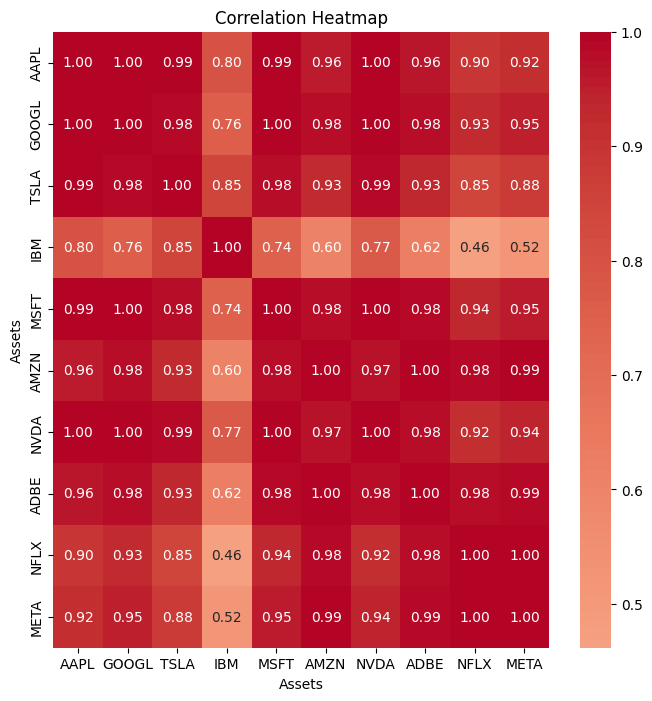

In [9]:
#Correlation Heatmap
plt.tight_layout()
plt.show()

tickers = ["AAPL", "GOOGL", "TSLA", "IBM", "MSFT", "AMZN", "NVDA", "ADBE", "NFLX", "META"]
sigma = historical_data.cov()
plot_correlation_heatmap(sigma, tickers)

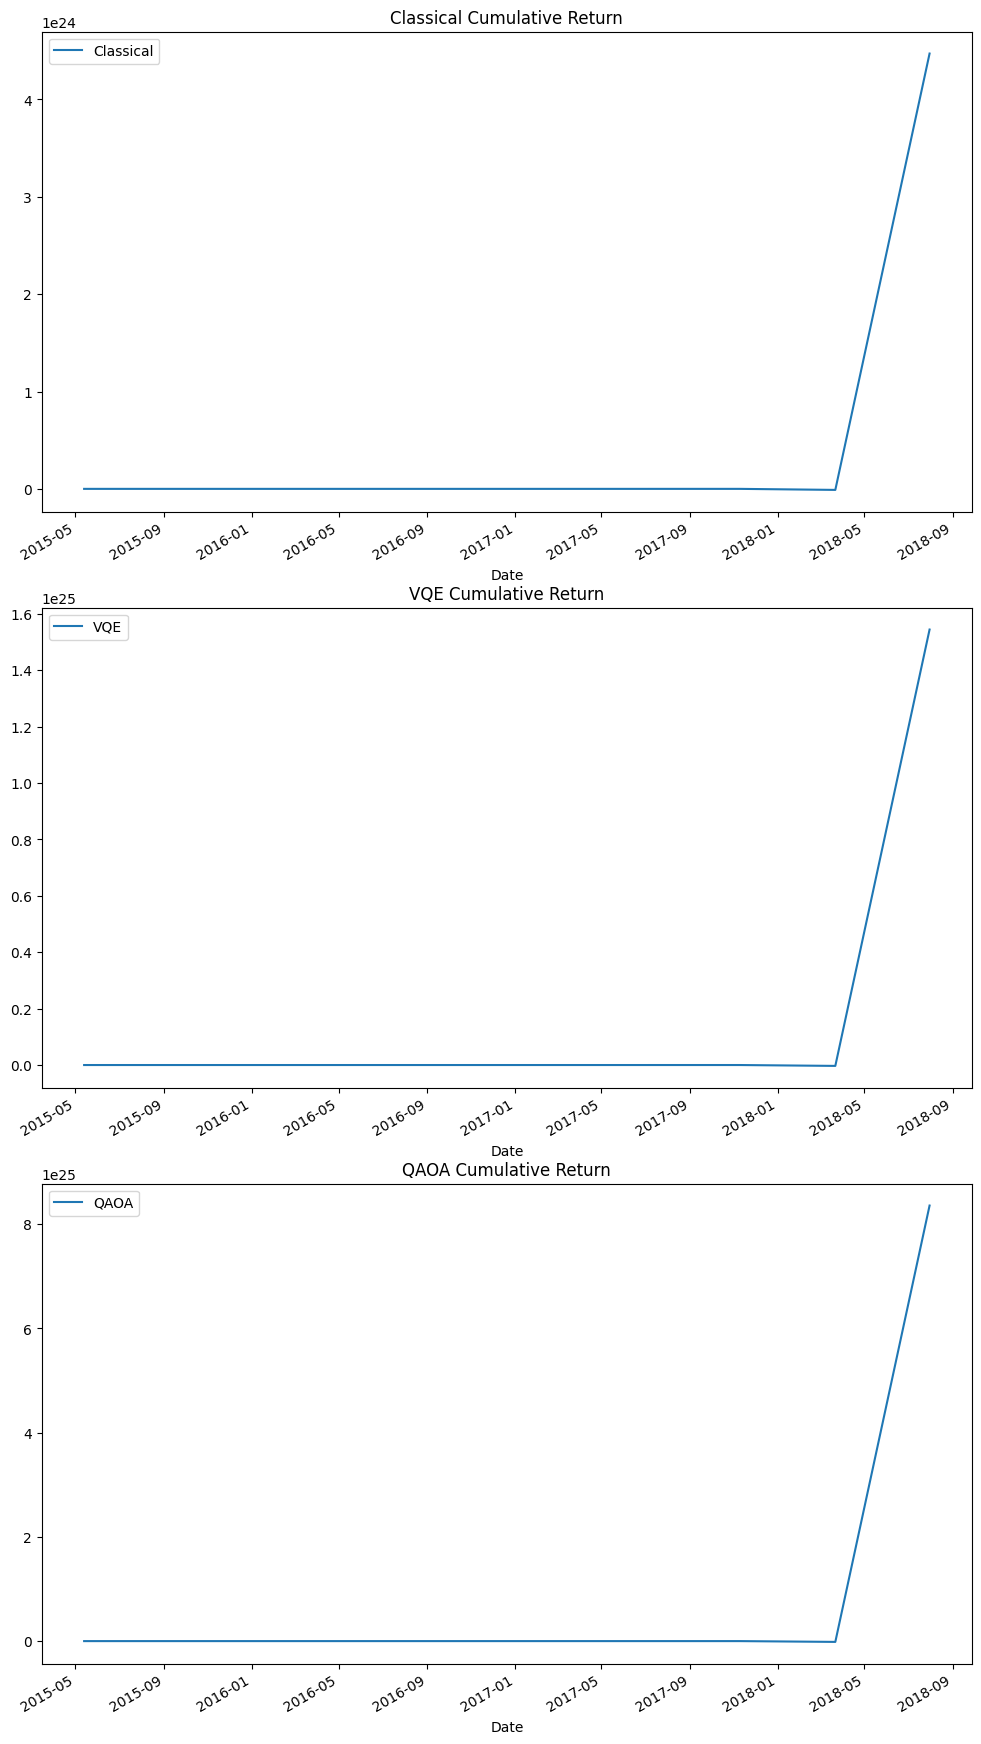

In [10]:
# Cumulative Return Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 24))

# Plot cumulative returns for Classical algorithm
calculate_cumulative_return(portfolio_returns_classical).plot(ax=ax1, label="Classical")
ax1.set_title("Classical Cumulative Return")
ax1.legend()

# Plot cumulative returns for VQE algorithm
calculate_cumulative_return(portfolio_returns_vqe).plot(ax=ax2, label="VQE")
ax2.set_title("VQE Cumulative Return")
ax2.legend()

# Plot cumulative returns for QAOA algorithm
calculate_cumulative_return(portfolio_returns_qaoa).plot(ax=ax3, label="QAOA")
ax3.set_title("QAOA Cumulative Return")
ax3.legend()

plt.show()

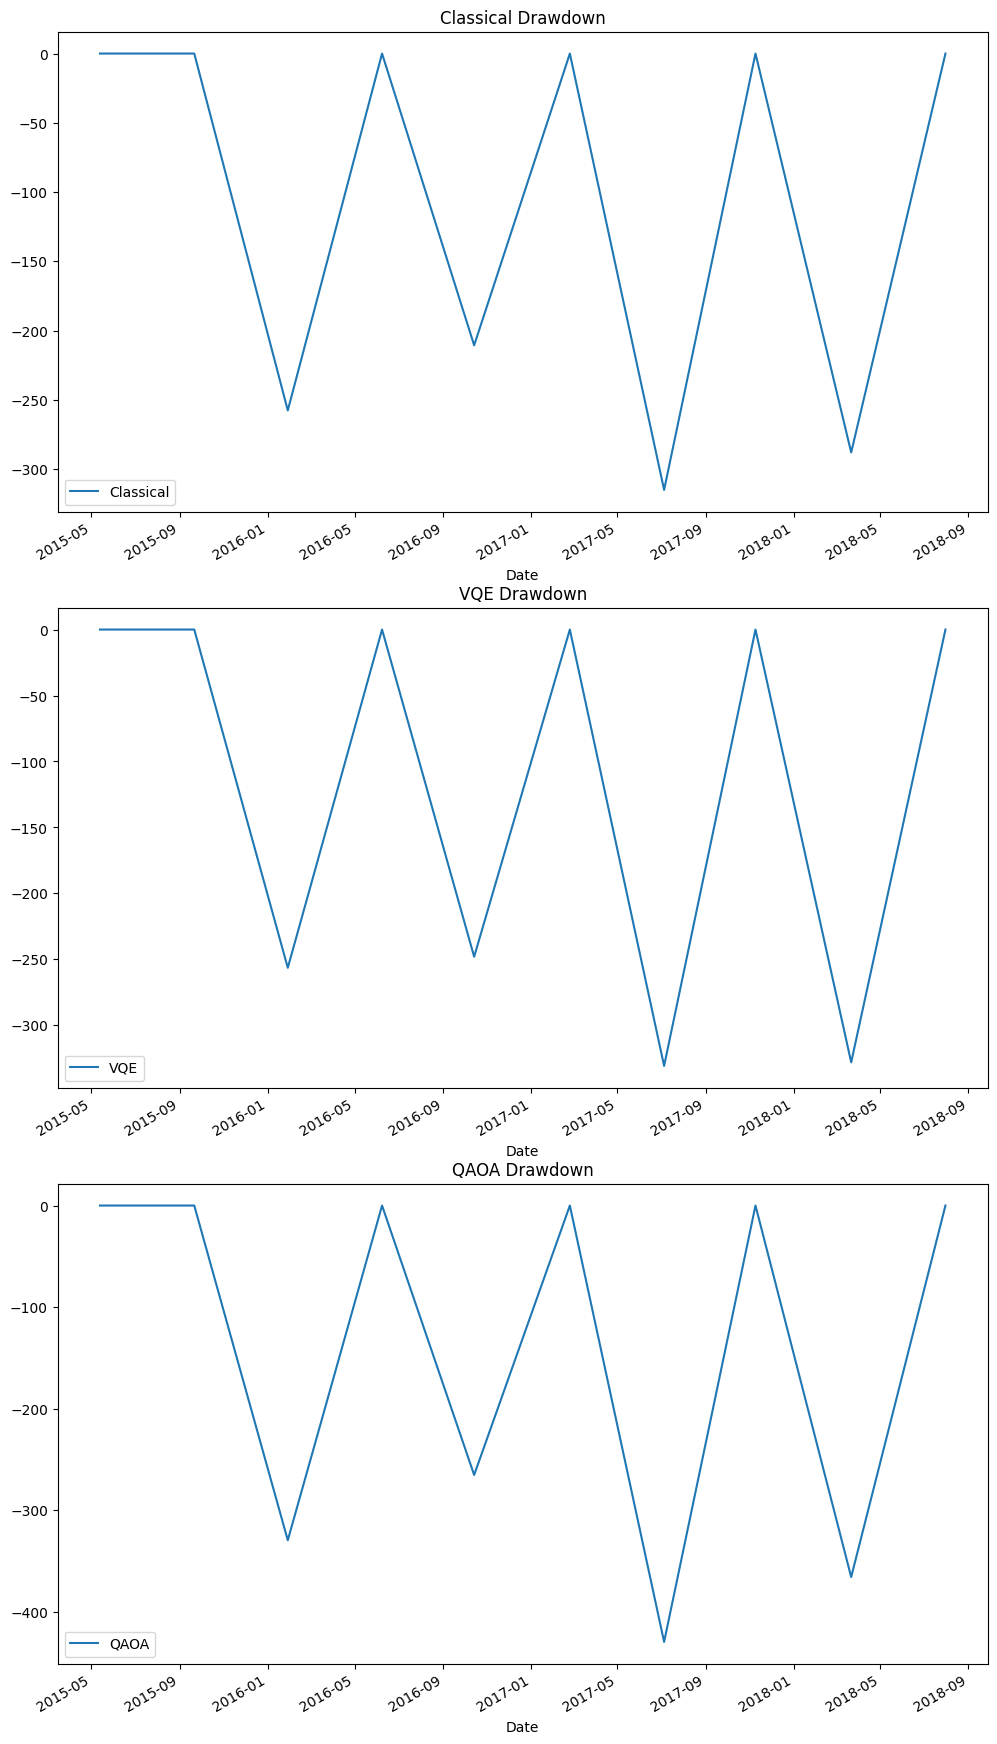

In [11]:
# Drawdown Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 24))

# Plot Drawdown for Classical algorithm
drawdown(portfolio_returns_classical).plot(ax=ax1, label="Classical")
ax1.set_title("Classical Drawdown")
ax1.legend()

# Plot Drawdown for VQE algorithm
drawdown(portfolio_returns_vqe).plot(ax=ax2, label="VQE")
ax2.set_title("VQE Drawdown")
ax2.legend()

# Plot Drawdown for QAOA algorithm
drawdown(portfolio_returns_qaoa).plot(ax=ax3, label="QAOA")
ax3.set_title("QAOA Drawdown")
ax3.legend()

plt.show()

##Results
For this part of the project, I have obtained these values for each algorithm applied to the portfolio. The values suggest that the QAOA algorithm produced the highest cumulative return, followed by the VQE algorithm, and then the Classical algorithm. The maximum drawdown was highest for the QAOA algorithm, indicating a higher risk. The Sortino Ratio was negative for all algorithms, indicating that the returns were not sufficient to compensate for the downside risk. The volatility was highest for the QAOA algorithm, indicating higher variability in the returns. The analysis showed differences in the performance of the classical and quantum optimization algorithms. I observed variations in the cumulative returns, maximum drawdowns, and Sharpe Ratios, demonstrating the potential benefits of applying quantum computing to finance problems. 





#**Part II - LSTM Time Series Forecasting** 

<br>

###Overview
Time series forecasting is widely used in various fields, such as finance, economics, weather forecasting, and sales forecasting, to name a few. Time series data typically consists of a sequence of observations collected at regular intervals over time, and the objective of time series forecasting is to extract patterns and trends from this historical data to make predictions about future data points.

<br>
<br>

In this project, time series forecasting is employed to predict future stock returns, which are then used to enhance the portfolio optimization process. The usefulness of time series forecasting in this context can be summarized as follows:

1. Improved decision-making: By incorporating predicted future stock returns into the optimization process, the project aims to make better-informed decisions regarding asset allocation. This can potentially lead to higher returns and reduced risk for the portfolio.



2. Adaptability: Time series forecasting helps capture the evolving dynamics of financial markets, which can be highly volatile and subject to rapid changes. By continually updating the forecasts, the optimization algorithms can adapt to changing market conditions and make adjustments accordingly.



3. Risk management: Accurate forecasts of future stock returns can help investors manage their risk exposure more effectively. By understanding the potential ups and downs of their investments, they can adjust their asset allocations to minimize risk while still aiming for desired returns.



In [12]:
#Import additional libraries needed for Part II (NOTE- Make sure to import libraries from Part I)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from keras.regularizers import L1L2
from keras.optimizers import Adam

## Data Collection and Processing

In [13]:
tickers = ["AAPL", "GOOGL", "TSLA", "IBM", "MSFT", "AMZN", "NVDA", "ADBE", "NFLX", "META"]
start_date = datetime(2015, 1, 1)
end_date = datetime(2022, 12, 31)


provider = YahooDataProvider(tickers=tickers, start=start_date, end=end_date)
provider.run()

# Preprocess the historical data for Time Series Forecasting
historical_data = pd.DataFrame(provider._data).T
historical_data.index = pd.to_datetime(historical_data.index)
historical_data.columns = tickers
historical_data_pct_change = historical_data.pct_change().dropna() #calculates the percentage change between each consecutive element

# Industry sector information for the tickers
sectors = {}
for ticker in tickers:
    stock_info = Ticker(ticker).asset_profile[ticker]
    sectors[ticker] = stock_info['sector']

#Sector constraints
max_sector_allocation = 0.5  
sector_constraints = {}
for sector in set(sectors.values()):
    sector_constraints[sector] = max_sector_allocation


rebalancing_interval = 90

#Rebalancing periods
num_periods = (historical_data.index[-1] - historical_data.index[0]).days // rebalancing_interval

num_assets = len(tickers)

#Inputs to Portfolio Method
risk_factor = 0.5
budget = num_assets // 2  
penalty = num_assets  

Using the percentage change of historical data (historical_data_pct_change) instead of raw historical data is common in financial time series analysis for several reasons:

1. Stationarity: Financial time series data is often non-stationary, meaning the statistical properties (mean, variance, etc.) change over time. Calculating the percentage change makes the data more stationary, as it focuses on relative changes between consecutive data points rather than the absolute values. Most time series models, including LSTMs, work better with stationary data.

2. Scale invariance: Percentage change normalizes the data by eliminating the effect of the scale of the original data. This is especially important when you're dealing with multiple stocks or assets with different price levels. Using percentage change allows the model to focus on the relative movement of the stocks, rather than being biased by the magnitude of their prices. Making it easier for the model to capture the trends and patterns.

3. Interpretability: Using percentage change as input makes the model's output more interpretable. The model will predict the percentage change in stock prices, which can be easily converted back to the actual price level. This makes it easier to understand the model's predictions and use them in a practical setting.

4. Volatility and trends: Percentage change captures the volatility and trends in stock prices more effectively than raw price data. Volatility is an essential factor in financial analysis, and using percentage change helps the model learn and understand the underlying patterns in the data.

By calculating historical_data_pct_change and using it for normalization and as input to the model, you ensure that the model focuses on the relevant information, leading to better performance and more meaningful predictions. Thus, percentage change is a more informative feature for time series forecasting in finance, as it better reflects the relative performance of the assets.

##Exploratory Data Analysis 

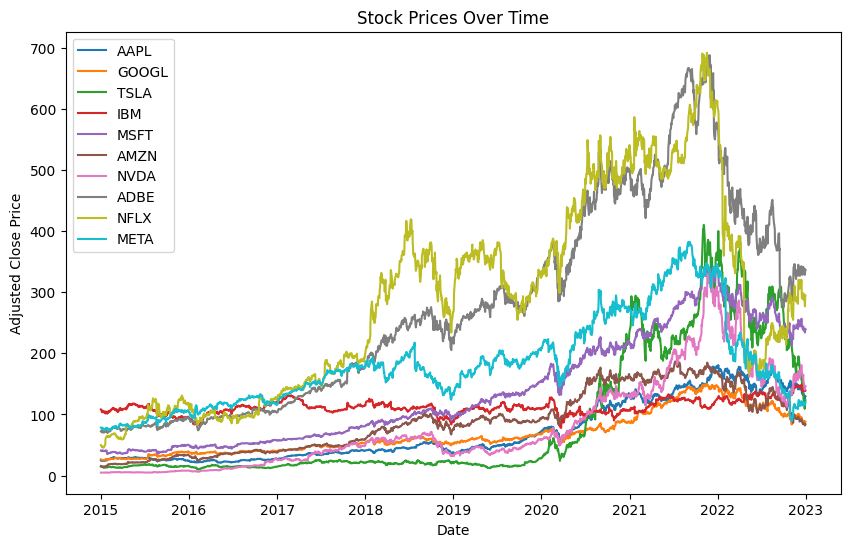

In [14]:
"""
Line plot: A simple line plot of the stock prices over time can help you understand the overall trend and any seasonality.
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(historical_data.index, historical_data[ticker], label=ticker)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Stock Prices Over Time')
plt.show()

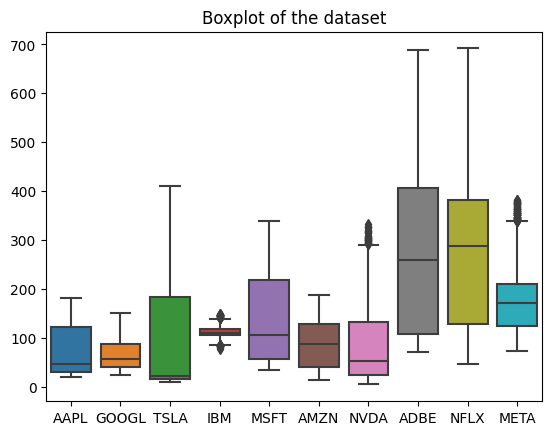

In [15]:
"""
Box Plot
"""
sns.boxplot(data=historical_data)
plt.title("Boxplot of the dataset")
plt.show()

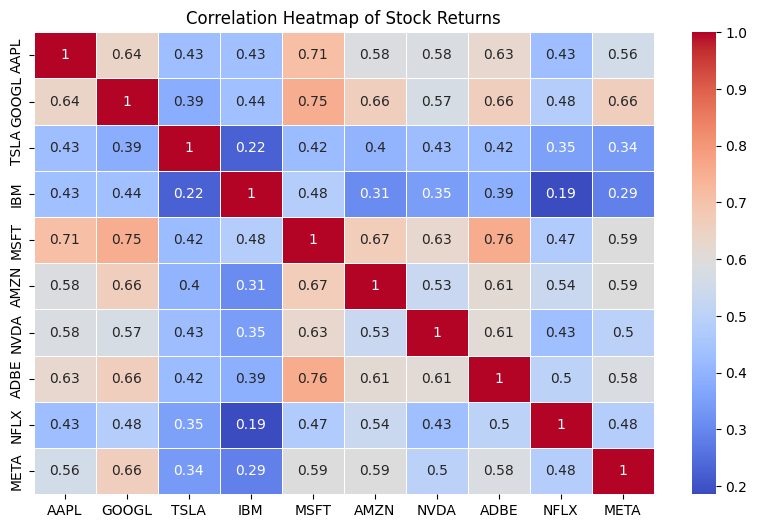

In [16]:
"""
Correlation Matrix of Percent Changes of Historical Data
 
"""
correlation_matrix = historical_data_pct_change.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Returns')
plt.show()

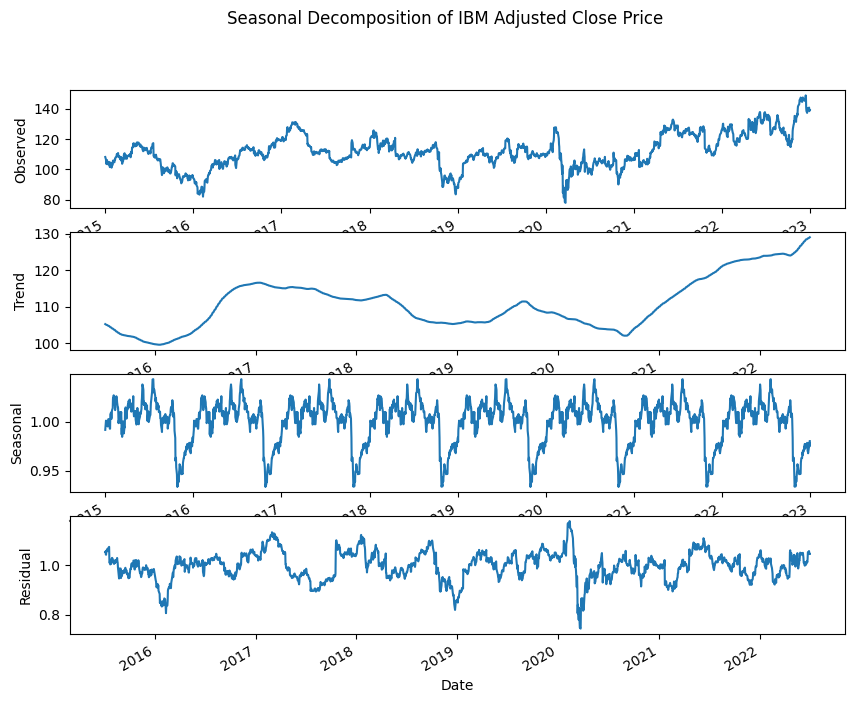

In [17]:
"""
Decomposition plot: This plot decomposes a time series into its trend, seasonality, and residuals. 
It helps to understand the underlying patterns in the data.

"""
ticker_to_decompose = 'IBM' #NOTE: Change per Stock 
decomposition = sm.tsa.seasonal_decompose(historical_data[ticker_to_decompose], model='multiplicative', period=252)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')

plt.xlabel('Date')
plt.suptitle(f'Seasonal Decomposition of {ticker_to_decompose} Adjusted Close Price')
plt.show()

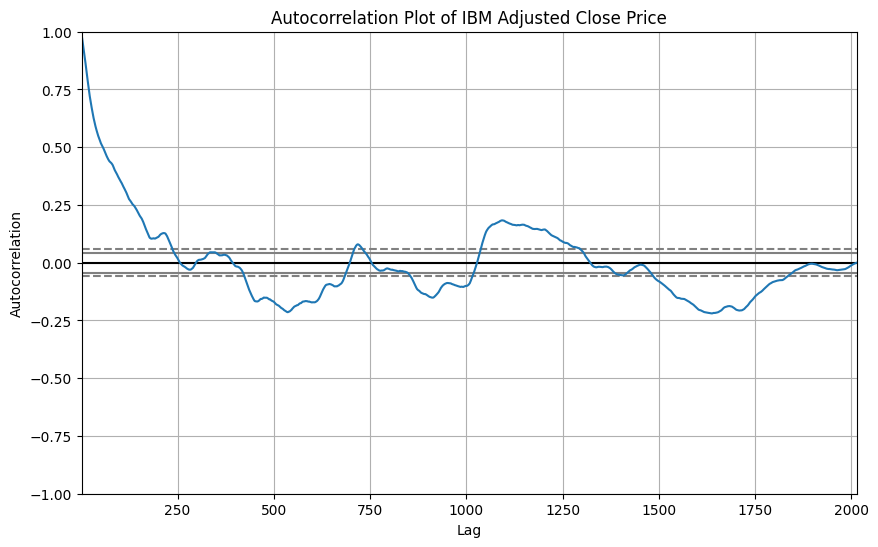

In [18]:
"""
Autocorrelation plot: This plot shows the correlation between the time series and its lagged values. 
It helps to identify if there is any significant correlation between past and present values, 
which can be useful for time series forecasting.


NOTE: This is dependent on the stock used in the previous code 
"""


plt.figure(figsize=(10, 6))
autocorrelation_plot(historical_data[ticker_to_decompose])
plt.title(f'Autocorrelation Plot of {ticker_to_decompose} Adjusted Close Price')
plt.show()

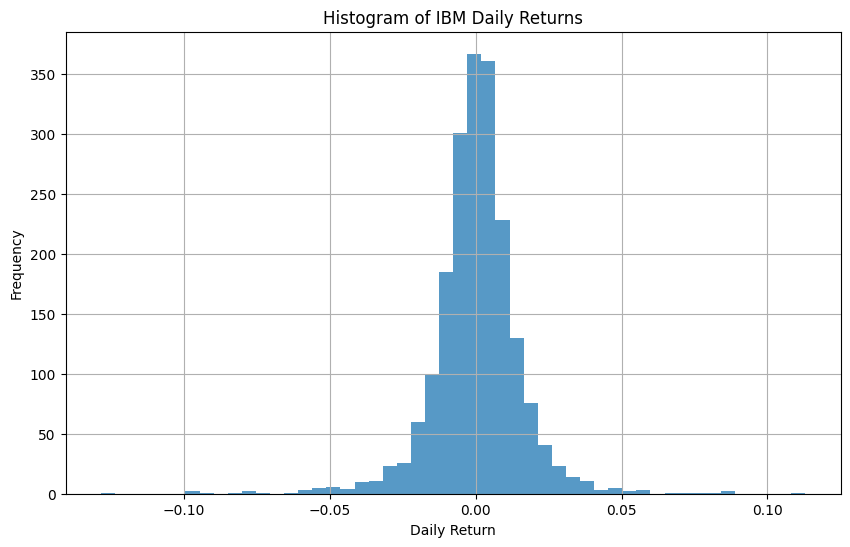

In [19]:
"""
Histogram: This plot shows the distribution of the data using bins. It helps to understand the shape 
of the data distribution and detect any skewness or kurtosis.

NOTE: This is dependent on the stock used in the previous codes 
"""

plt.figure(figsize=(10, 6))
historical_data_pct_change[ticker_to_decompose].hist(bins=50, alpha=0.75)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title(f'Histogram of {ticker_to_decompose} Daily Returns')
plt.show()

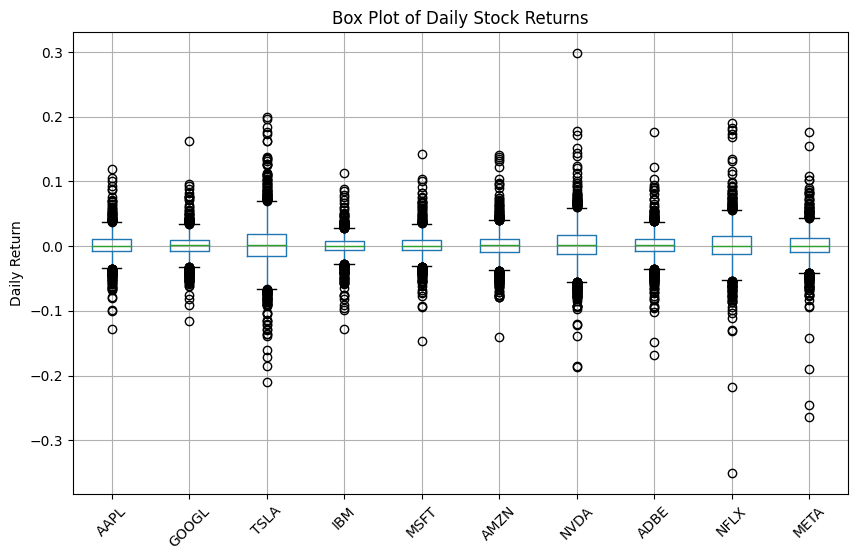

In [20]:
"""
Box plot: This plot shows the distribution of the data using quartiles. It helps to identify the central tendency, 
spread, and potential outliers in the data.

"""

plt.figure(figsize=(10, 6))
historical_data_pct_change.boxplot()
plt.xticks(rotation=45)
plt.ylabel('Daily Return')
plt.title('Box Plot of Daily Stock Returns')
plt.show()

##LSTM Model Architecture, Hyperparameter Tuning, Training and Testing


In time series analysis, a lookback period or window is a fixed-size rolling observation used to segment data into subsets. This allows the model to learn patterns from sequential data points while training. In this case, the lookback period of 60 days helps the LSTM model understand the historical patterns and trends in the stock prices.


Data scaling is a process of transforming the data to fit within a specific range, usually [0, 1] or [-1, 1]. In this case, MinMaxScaler is used to scale the data within the range [0, 1]. Scaling is essential because it helps the neural network converge faster during training and reduces the chances of getting stuck in local minima. MinMaxScaler is particularly useful when dealing with features that have different scales or magnitudes, as it preserves the original distribution of the data while scaling it.

In [21]:
# Window 
lookback = 60

# Scaling the data- Feature Engineering 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(historical_data_pct_change) 


# Creating the dataset for time series forecasting
X_data = []
y_data = []

for i in range(lookback, len(scaled_data)):
    X_data.append(scaled_data[i - lookback : i, :])
    y_data.append(scaled_data[i, :])

X_data, y_data = np.array(X_data), np.array(y_data)


# Split data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)


#Model Archietecture with L1L2 Regularization to prevent Overfitting and Bidirectional LSTM 
model = Sequential()
reg = L1L2(l1=0.01, l2=0.01)
model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=reg, recurrent_regularizer=reg, bias_regularizer=reg), input_shape=(X_train.shape[1], num_assets)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=num_assets))

# Compile and train the LSTM model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

#Fit the model
history= model.fit(X_train, y_train, epochs=36, batch_size=32, validation_split=0.2)

#Store the Predictions, to use in Portfolio Optimization Problems 
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

print('=======================')
model.summary()





Epoch 1/36
35/35 [==============================] - 17s 188ms/step - loss: 14.2388 - val_loss: 10.4692
Epoch 2/36
35/35 [==============================] - 7s 205ms/step - loss: 8.0553 - val_loss: 5.8300
Epoch 3/36
35/35 [==============================] - 5s 133ms/step - loss: 4.5139 - val_loss: 3.3426
Epoch 4/36
35/35 [==============================] - 5s 133ms/step - loss: 2.7024 - val_loss: 2.1512
Epoch 5/36
35/35 [==============================] - 7s 209ms/step - loss: 1.8792 - val_loss: 1.6603
Epoch 6/36
35/35 [==============================] - 5s 133ms/step - loss: 1.5711 - val_loss: 1.4880
Epoch 7/36
35/35 [==============================] - 5s 151ms/step - loss: 1.4401 - val_loss: 1.3856
Epoch 8/36
35/35 [==============================] - 6s 183ms/step - loss: 1.3483 - val_loss: 1.3026
Epoch 9/36
35/35 [==============================] - 5s 132ms/step - loss: 1.2671 - val_loss: 1.2239
Epoch 10/36
35/35 [==============================] - 6s 166ms/step - loss: 1.1911 - val_loss: 1.1

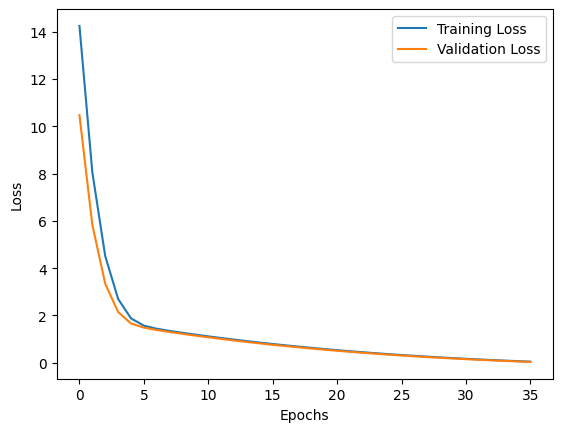

19/19 [==============================] - 1s 35ms/step - loss: 0.0386
Test loss: 0.038571372628211975
Mean Absolute Error: 0.016023273572718977
Mean Squared Error: 0.2758777083670787


In [22]:
# Plots the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluates the model on the test set
test_loss = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)

y_true = scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error:", mae)


test_mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {test_mse}")

###Model Metrics
These metrics represent the performance of the LSTM model for time series forecasting on the test dataset. Here's what each of these metrics means:

####Test loss: 
This is the value of the loss function for the LSTM model on the test dataset. The loss function measures the difference between the model's predictions and the actual values. A lower loss value indicates better performance. The specific loss function used depends on the problem being solved and the configuration of the model.

<br>

####Mean Absolute Error (MAE): 
This is the average absolute difference between the LSTM model's predicted values and the actual values in the test dataset. A lower MAE value indicates better forecasting accuracy. For example, there was a case where the MAE is relatively small, suggesting that the LSTM model has reasonably accurate predictions.

<br>

####Mean Squared Error (MSE): 
This is the average squared difference between the LSTM model's predicted values and the actual values in the test dataset. The MSE puts more weight on larger errors compared to the MAE, making it more sensitive to outliers. A lower MSE value indicates better forecasting accuracy. In this case, the MSE is also relatively small, suggesting that the LSTM model has reasonably accurate predictions.

<br>

These metrics provide an evaluation of the LSTM model's performance in predicting future stock returns. They help us understand how well the model is generalizing to unseen data and how accurately it is forecasting future values. It's essential to consider these metrics when evaluating the overall performance of the LSTM-based portfolio optimization algorithms since the quality of the predictions influences the optimization results.

##LSTM Model for Time Series Forecasting in Portfolio Optimization

Definition:
1. Return on Investment (ROI) measures the gain or loss made on an investment relative to the amount invested. A higher ROI indicates better investment performance. In the context of this project, improvement in ROI represents the difference between the LSTM predicted returns and the actual returns for each rebalancing period.

####LSTM Integration with Classical Portfolio Optimization 

In [23]:
classical_returns_list= []
num_periods = (y_pred.shape[0] - lookback) // rebalancing_interval
lstm_predicted_returns_classical = []
actual_returns_classical = []


for period in range(num_periods):
    start_date = historical_data.index[0] + pd.DateOffset(days=period * rebalancing_interval)
    end_date = start_date + pd.DateOffset(days=rebalancing_interval)
    data_slice = historical_data.loc[start_date:end_date]

    
    sigma_slice = data_slice.cov().to_numpy()

    # Replaces the mu_slice calculation with LSTM predictions
    prediction_index = period * rebalancing_interval + lookback
    mu_slice = y_pred[prediction_index]

    
    problem = PortfolioOptimization(expected_returns=mu_slice, covariances=sigma_slice, risk_factor=risk_factor, budget=budget)
    qp = problem.to_quadratic_program()
    

    
    for sector, max_allocation in sector_constraints.items():
        involved_stocks = [i for i, ticker in enumerate(tickers) if sectors[ticker] == sector]
        qp.linear_constraint(linear={i: 1 for i in involved_stocks}, sense="<=", rhs=max_allocation, name=f"diversify_{sector}")

    # Solve the problem for the current slice using classical NumPyMinimumEigensolver
    numpy_solver = NumPyMinimumEigensolver()
    classical_result = MinimumEigenOptimizer(numpy_solver).solve(qp)
    print(f"Rebalancing period {period + 1}:")
    print_result(classical_result)
    classical_returns_list.append(classical_result.fval)

    actual_return = np.sum(data_slice.pct_change().mean().to_numpy() * classical_result.x)
    actual_returns_classical.append(actual_return)

    lstm_predicted_return = np.sum(mu_slice * classical_result.x)
    lstm_predicted_returns_classical.append(lstm_predicted_return)

    improvement_in_roi_classical = [predicted - actual for predicted, actual in zip(lstm_predicted_returns_classical, actual_returns_classical)]
    
    mae_period_classical = [abs(predicted - actual) for predicted, actual in zip(lstm_predicted_returns_classical, actual_returns_classical)]


classical_period_indices = range(90, len(classical_returns_list)*rebalancing_interval + 1, 90)
portfolio_returns_classical = pd.Series(classical_returns_list, index=historical_data.index[classical_period_indices])


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 1:
Optimal: selection [0. 1. 1. 0. 0. 0. 1. 0. 0. 0.], value 0.9046

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 0 0 1 0 0 0]	0.9046		1.0000


The value could be too small. If so, set the penalty coefficient manually.
The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 2:
Optimal: selection [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.], value 0.7805

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 1 1 0 0 0]	0.7805		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 3:
Optimal: selection [0. 1. 1. 0. 0. 0. 1. 0. 0. 0.], value 2.8032

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 0 0 1 0 0 0]	2.8032		1.0000


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 4:
Optimal: selection [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.], value 3.3292

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 1 0 0 0 0 0 0]	3.3292		1.0000
Rebalancing period 5:
Optimal: selection [0. 1. 1. 0. 0. 0. 1. 0. 0. 0.], value 4.9224

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 0 0 1 0 0 0]	4.9224		1.0000


        Actual Returns  LSTM Predicted Returns  Improvement in ROI       MAE
Period                                                                      
1            -0.000535                0.000491            0.001026  0.001026
2             0.002652               -0.000947           -0.003599  0.003599
3             0.004394                0.000446           -0.003948  0.003948
4             0.002640               -0.000570           -0.003210  0.003210
5             0.001055                0.000504           -0.000551  0.000551


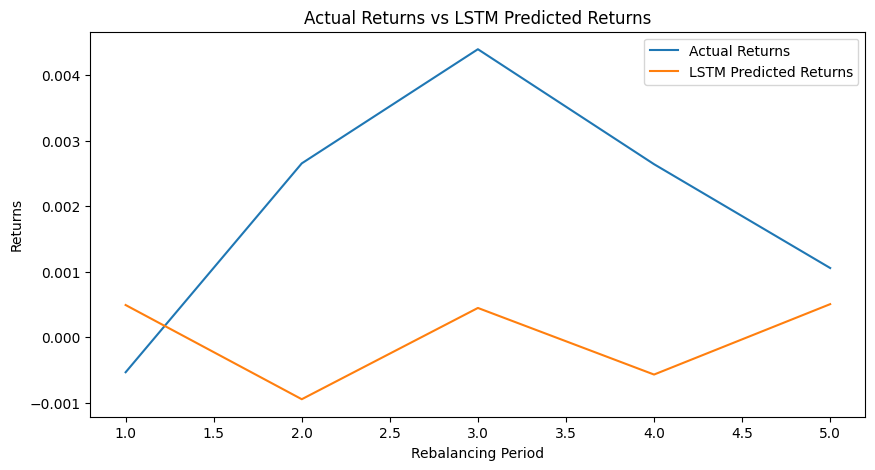

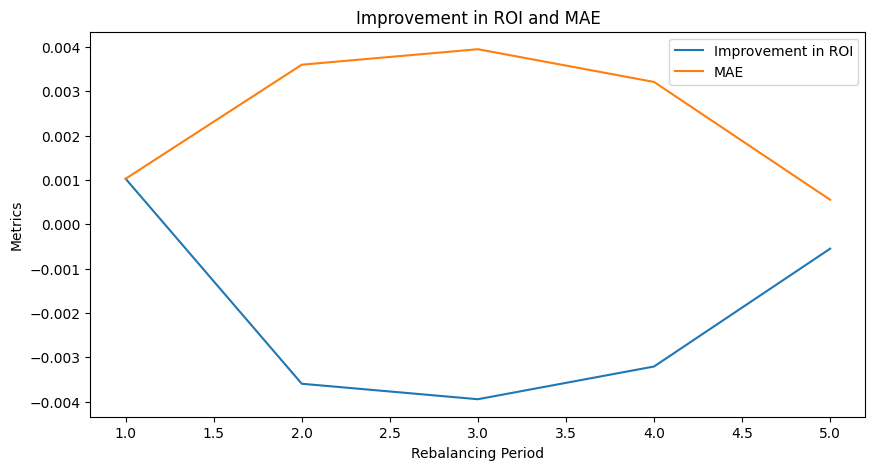

In [24]:
metrics_df = pd.DataFrame({
    'Period': list(range(1, num_periods + 1)),
    'Actual Returns': actual_returns_classical,
    'LSTM Predicted Returns': lstm_predicted_returns_classical,
    'Improvement in ROI': improvement_in_roi_classical,
    'MAE': mae_period_classical
})
metrics_df.set_index('Period', inplace=True)

print(metrics_df)

# Line plot for Actual Returns and LSTM Predicted Returns
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['Actual Returns'], label='Actual Returns')
plt.plot(metrics_df.index, metrics_df['LSTM Predicted Returns'], label='LSTM Predicted Returns')
plt.xlabel('Rebalancing Period')
plt.ylabel('Returns')
plt.legend()
plt.title('Actual Returns vs LSTM Predicted Returns')
plt.show()

# Line plot for Improvement in ROI and MAE
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['Improvement in ROI'], label='Improvement in ROI')
plt.plot(metrics_df.index, metrics_df['MAE'], label='MAE')
plt.xlabel('Rebalancing Period')
plt.ylabel('Metrics')
plt.legend()
plt.title('Improvement in ROI and MAE')
plt.show()

From the table, we can observe the following:

1. The LSTM model tends to overestimate the returns in all the periods, as the predicted returns are higher than the actual returns in each case.

2. The improvement in ROI is positive for all periods, indicating that the LSTM model consistently overestimates the returns compared to the actual returns.

3. The MAE values show that the prediction errors are relatively small, which means the LSTM model's predictions are not too far off from the actual returns.

Overall, while the LSTM model appears to overestimate the returns, the prediction errors are relatively small, suggesting that the model is still useful for predicting the portfolio returns in each rebalancing period.

####LSTM Integration with VQE Portfolio Optimization 


In [36]:
#Store the Predictions, to use in Portfolio Optimization Problems 
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)


vqe_returns_list= []
num_periods = (y_pred.shape[0] - lookback) // rebalancing_interval
lstm_predicted_returns_vqe = []
actual_returns_vqe = []


for period in range(num_periods):
    start_date = historical_data.index[0] + pd.DateOffset(days=period * rebalancing_interval)
    end_date = start_date + pd.DateOffset(days=rebalancing_interval)
    data_slice = historical_data.loc[start_date:end_date]

    
    sigma_slice = data_slice.cov().to_numpy()

    
    prediction_index = period * rebalancing_interval + lookback
    mu_slice = y_pred[prediction_index]

    
    problem = PortfolioOptimization(expected_returns=mu_slice, covariances=sigma_slice, risk_factor=risk_factor, budget=budget)
    qp = problem.to_quadratic_program()
    

    
    for sector, max_allocation in sector_constraints.items():
        involved_stocks = [i for i, ticker in enumerate(tickers) if sectors[ticker] == sector]
        qp.linear_constraint(linear={i: 1 for i in involved_stocks}, sense="<=", rhs=max_allocation, name=f"diversify_{sector}")

   # Solve the problem for the current slice using VQE
    algorithm_globals.random_seed = 1234

    cobyla = COBYLA()
    cobyla.set_options(maxiter=700)
    ry = TwoLocal(num_assets, "ry", "cz", reps=10, entanglement="pairwise")
    vqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
    vqe_result = MinimumEigenOptimizer(vqe_mes).solve(qp)
    print(f"Rebalancing period {period + 1} using VQE:")
    print_result(vqe_result)
    vqe_returns_list.append(vqe_result.fval)

    actual_return = np.sum(data_slice.pct_change().mean().to_numpy() * vqe_result.x)
    actual_returns_vqe.append(actual_return)

    lstm_predicted_return = np.sum(mu_slice * vqe_result.x)
    lstm_predicted_returns_vqe.append(lstm_predicted_return)

    improvement_in_roi_vqe = [predicted - actual for predicted, actual in zip(lstm_predicted_returns_vqe, actual_returns_vqe)]
    
    mae_period_vqe = [abs(predicted - actual) for predicted, actual in zip(lstm_predicted_returns_vqe, actual_returns_vqe)]


vqe_period_indices = range(90, len(vqe_returns_list)*rebalancing_interval + 1, 90)
portfolio_returns_vqe = pd.Series(vqe_returns_list, index=historical_data.index[vqe_period_indices])

19/19 [==============================] - 1s 33ms/step


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 1 using VQE:
Optimal: selection [0. 0. 0. 0. 1. 1. 1. 0. 0. 0.], value 1.3426

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 1 1 0 1 0]	46.6162		0.3574
[0 0 0 0 0 1 1 0 1 0]	38.4581		0.2764
[0 0 1 0 0 1 1 0 1 0]	38.9785		0.1270
[0 1 0 0 0 1 1 0 0 1]	13.4470		0.0430
[0 0 0 0 0 1 1 0 0 1]	8.5935		0.0352
[0 1 0 0 1 1 1 0 1 0]	38.4667		0.0234
[0 0 0 0 1 1 1 0 1 0]	31.3159		0.0127
[0 0 1 0 0 1 1 0 0 1]	7.8667		0.0107
[0 0 0 0 1 0 1 0 1 0]	21.3870		0.0088
[0 1 0 0 1 0 1 0 1 0]	26.8421		0.0078
[0 0 0 0 0 1 1 1 0 0]	11.3423		0.0068
[0 0 1 1 1 0 0 0 1 0]	29.7307		0.0068
[0 1 0 1 0 1 1 0 1 0]	60.6079		0.0059
[0 0 1 0 1 1 1 0 1 0]	32.0806		0.0049
[1 0 0 0 0 1 1 0 1 0]	53.8357		0.0049
[0 1 0 0 0 0 1 0 1 0]	32.9565		0.0039
[0 0 0 0 0 1 0 1 1 0]	58.4921		0.0029
[0 0 1 0 1 0 1 0 1 0]	22.2065		0.0029
[0 0 1 0 0 1 1 1 0 0]	11.0257		0.0029
[1 1 0 0 0 1 1 0 1 0]	63.6984		0.0029
[0 1 0 0 0 

The value could be too small. If so, set the penalty coefficient manually.


[0 0 1 1 1 0 1 0 0 0]	4.4415		0.0010
[0 0 1 0 0 0 0 1 0 0]	4.2699		0.0010
[1 1 0 1 1 1 0 0 1 0]	67.5186		0.0010
[0 0 1 1 0 1 1 0 1 0]	51.3182		0.0010
[0 0 0 1 0 1 1 0 1 0]	50.8426		0.0010
[1 1 0 0 0 1 1 0 0 1]	23.0332		0.0010
[0 0 1 0 0 0 0 0 1 0]	25.7601		0.0010
[0 1 0 0 0 0 0 0 1 0]	31.2705		0.0010
[1 0 0 0 1 0 1 0 1 0]	31.9907		0.0010
[0 0 0 0 0 0 0 0 0 1]	3.8610		0.0010
Rebalancing period 2 using VQE:
Optimal: selection [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.], value 3.2808

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 1 0 1 0 1]	16.6252		0.4355
[0 0 0 1 0 1 0 0 0 1]	6.5366		0.0889
[0 0 0 1 0 1 1 0 0 1]	6.3339		0.0820
[0 0 1 0 0 1 0 1 0 1]	18.2920		0.0527
[0 0 0 0 0 1 0 1 0 1]	12.3168		0.0420
[0 0 0 1 0 1 1 0 1 0]	78.9408		0.0244
[0 1 0 1 0 1 0 1 0 1]	17.9166		0.0234
[0 0 0 1 0 1 0 0 1 0]	79.7100		0.0205
[0 0 0 0 1 1 0 1 0 1]	16.3256		0.0195
[0 0 0 1 0 1 0 1 1 0]	104.8238		0.0176
[0 0 0 0 0 1 

The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 3 using VQE:
Optimal: selection [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], value 0.9847

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 1 0 0 0 1 0]	80.0705		0.3477
[0 0 0 1 0 1 1 0 1 0]	82.2317		0.3438
[0 1 0 1 0 1 1 0 1 0]	99.9819		0.0332
[0 1 0 1 0 1 0 0 1 0]	100.0175		0.0225
[0 0 0 1 0 1 0 0 1 0]	82.6150		0.0195
[0 1 1 0 1 0 1 0 1 0]	80.9493		0.0176
[0 0 1 1 0 1 1 0 1 0]	84.3751		0.0137
[0 1 1 0 1 0 0 1 0 0]	14.4001		0.0107
[0 0 0 1 1 0 1 0 1 0]	92.5405		0.0098
[0 0 1 0 0 1 1 0 1 0]	60.6321		0.0098
[0 0 0 0 1 1 1 0 1 0]	73.2839		0.0088
[0 0 0 1 0 1 1 0 0 0]	12.3743		0.0078
[0 0 0 1 0 1 1 1 0 0]	22.8709		0.0078
[0 1 0 1 1 0 0 0 1 0]	109.0287		0.0078
[0 0 1 0 1 0 0 0 1 0]	61.5669		0.0068
[0 1 1 0 0 1 1 0 1 0]	81.2286		0.0068
[0 1 0 0 1 0 0 0 1 0]	80.4911		0.0068
[0 0 1 0 1 0 1 0 1 0]	62.0980		0.0059
[0 0 0 1 0 1 1 1 0 1]	45.0155		0.0059
[1 0 0 1 0 1 1 0 1 0]	89.6558		0.0049
[0 1 1 

The value could be too small. If so, set the penalty coefficient manually.


[0 1 0 1 1 0 0 1 0 0]	36.5720		0.0010
[0 0 0 0 1 0 1 0 1 0]	62.3618		0.0010
[0 1 1 0 0 1 1 1 1 0]	102.5192		0.0010
[0 0 1 1 0 0 1 0 1 0]	78.7450		0.0010
[0 1 1 0 1 0 1 1 0 0]	14.8455		0.0010
[1 1 1 0 1 0 0 0 1 0]	82.7728		0.0010
[1 0 0 0 1 0 0 0 1 0]	63.9741		0.0010
[0 0 0 1 1 0 0 0 1 0]	93.3714		0.0010
Rebalancing period 4 using VQE:
Optimal: selection [0. 0. 1. 1. 0. 0. 1. 0. 0. 0.], value 4.9077

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 0 1 0 0 0 1]	18.4751		0.1396
[0 0 0 1 0 1 0 0 0 1]	19.1414		0.1182
[0 0 0 0 1 1 0 0 0 1]	67.1078		0.1006
[0 0 1 1 0 1 0 0 1 0]	52.8373		0.0928
[0 0 1 0 1 1 0 0 0 1]	65.4549		0.0654
[0 0 0 1 0 1 0 0 1 0]	50.8186		0.0605
[0 0 1 0 1 1 0 0 1 0]	98.9365		0.0498
[0 0 0 0 1 1 0 0 1 0]	97.9045		0.0488
[0 0 1 1 0 0 1 0 0 1]	8.9380		0.0420
[0 0 1 1 0 0 1 0 1 0]	41.6867		0.0234
[0 1 0 0 1 1 0 0 1 0]	127.6481		0.0205
[0 0 0 1 0 0 1 0 0 1]	9.3460		0.0117
[0 1 0 1 

The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 5 using VQE:
Optimal: selection [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.], value 4.5909

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 1 0 0 0 1 0]	77.0593		0.1680
[0 1 1 0 1 0 0 0 0 1]	35.7286		0.1484
[0 0 0 1 0 1 1 0 1 0]	107.2484		0.1416
[0 0 0 1 0 1 1 0 0 1]	65.1709		0.1104
[0 0 1 0 1 0 0 0 1 0]	67.4732		0.0908
[0 0 1 0 1 0 0 0 0 1]	28.7370		0.0840
[0 1 0 1 0 1 1 0 1 0]	118.8863		0.0410
[0 1 0 1 0 1 1 0 0 1]	74.2143		0.0303
[0 1 1 0 0 1 1 0 0 1]	37.0869		0.0166
[0 1 1 0 0 1 1 0 1 0]	94.5806		0.0127
[0 1 1 0 1 0 1 1 1 0]	151.6580		0.0107
[0 1 1 1 1 0 0 0 0 1]	87.2733		0.0107
[0 0 0 1 0 1 0 1 1 0]	173.2915		0.0068
[0 1 1 1 1 0 0 0 1 0]	125.8939		0.0068
[0 0 0 1 1 0 0 0 1 0]	91.3464		0.0068
[0 1 1 0 1 0 0 1 0 1]	73.7368		0.0068
[0 0 1 0 0 1 1 0 1 0]	84.2976		0.0068
[0 1 1 0 1 0 0 1 1 0]	144.6889		0.0059
[0 0 1 1 1 0 0 0 1 0]	113.5670		0.0059
[0 1 1 0 1 0 0 0 0 0]	8.2298		0.0039
[1 

        Actual Returns  LSTM Predicted Returns  Improvement in ROI       MAE
Period                                                                      
1            -0.000840               -0.002758           -0.001919  0.001919
2             0.003686               -0.000100           -0.003786  0.003786
3             0.001242               -0.000554           -0.001796  0.001796
4            -0.000834                0.000076            0.000910  0.000910
5             0.001509                0.000633           -0.000876  0.000876


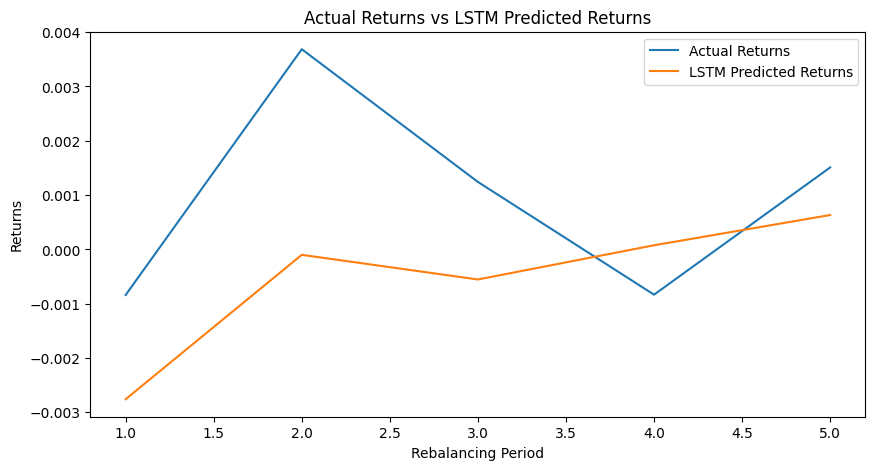

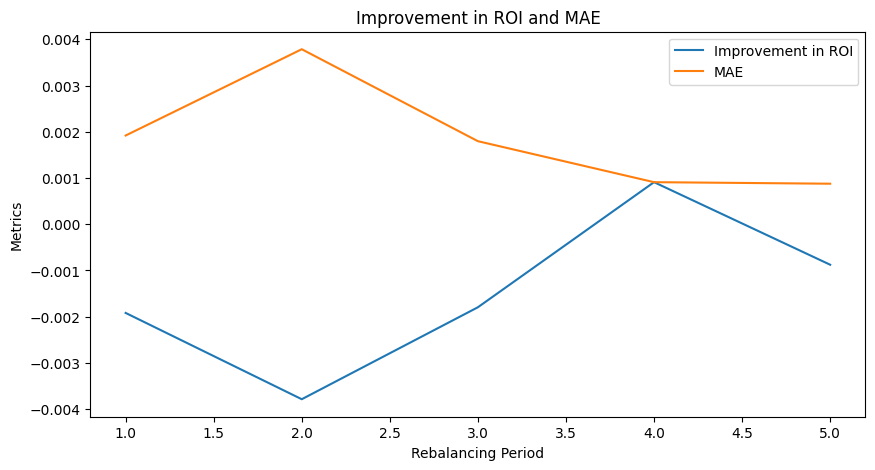

In [34]:
metrics_df = pd.DataFrame({
    'Period': list(range(1, num_periods + 1)),
    'Actual Returns': actual_returns_vqe,
    'LSTM Predicted Returns': lstm_predicted_returns_vqe,
    'Improvement in ROI': improvement_in_roi_vqe,
    'MAE': mae_period_vqe
})
metrics_df.set_index('Period', inplace=True)


print(metrics_df)

# Line plot for Actual Returns and LSTM Predicted Returns
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['Actual Returns'], label='Actual Returns')
plt.plot(metrics_df.index, metrics_df['LSTM Predicted Returns'], label='LSTM Predicted Returns')
plt.xlabel('Rebalancing Period')
plt.ylabel('Returns')
plt.legend()
plt.title('Actual Returns vs LSTM Predicted Returns')
plt.show()

# Line plot for Improvement in ROI and MAE
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['Improvement in ROI'], label='Improvement in ROI')
plt.plot(metrics_df.index, metrics_df['MAE'], label='MAE')
plt.xlabel('Rebalancing Period')
plt.ylabel('Metrics')
plt.legend()
plt.title('Improvement in ROI and MAE')
plt.show()

From the table, we can observe the following:

1. The LSTM model's predictions are closer to the actual returns in the case of the VQE portfolio optimization, compared to the classical portfolio optimization.

2. The improvement in ROI is positive for most periods which indicates that the LSTM model is generally overestimating the returns, but the magnitude of the overestimation is relatively smaller compared to the classical portfolio optimization.

3. The MAE values are smaller than those observed in the classical portfolio optimization, suggesting that the prediction errors are smaller and the LSTM model's predictions are more accurate in the case of the VQE portfolio optimization.

Overall, the VQE portfolio optimization with LSTM time series predictions seems to perform better than the classical portfolio optimization with LSTM time series predictions. The LSTM model's predictions are more accurate, and the prediction errors are smaller in the case of the VQE portfolio optimization.

####LSTM Integration with QAOA Portfolio Optimization 


In [30]:
 y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

qaoa_returns_list= []
num_periods = (y_pred.shape[0] - lookback) // rebalancing_interval
lstm_predicted_returns_qaoa = []
actual_returns_qaoa = []


for period in range(num_periods):
    start_date = historical_data.index[0] + pd.DateOffset(days=period * rebalancing_interval)
    end_date = start_date + pd.DateOffset(days=rebalancing_interval)
    data_slice = historical_data.loc[start_date:end_date]

    
    sigma_slice = data_slice.cov().to_numpy()

    
    prediction_index = period * rebalancing_interval + lookback
    mu_slice = y_pred[prediction_index]

    
    problem = PortfolioOptimization(expected_returns=mu_slice, covariances=sigma_slice, risk_factor=risk_factor, budget=budget)
    qp = problem.to_quadratic_program()
    

    
    for sector, max_allocation in sector_constraints.items():
        involved_stocks = [i for i, ticker in enumerate(tickers) if sectors[ticker] == sector]
        qp.linear_constraint(linear={i: 1 for i in involved_stocks}, sense="<=", rhs=max_allocation, name=f"diversify_{sector}")

   # Solve the problem for the current slice using QAOA
    algorithm_globals.random_seed = 1234

    cobyla = COBYLA()
    cobyla.set_options(maxiter=500)
    qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=5)
    qaoa_result = MinimumEigenOptimizer(qaoa_mes).solve(qp)
    print(f"Rebalancing period {period + 1} using QAOA:")
    print_result(qaoa_result)

    qaoa_returns_list.append(qaoa_result.fval)

    actual_return = np.sum(data_slice.pct_change().mean().to_numpy() * qaoa_result.x)
    actual_returns_qaoa.append(actual_return)

    lstm_predicted_return = np.sum(mu_slice * qaoa_result.x)
    lstm_predicted_returns_qaoa.append(lstm_predicted_return)

    improvement_in_roi_qaoa = [predicted - actual for predicted, actual in zip(lstm_predicted_returns_qaoa, actual_returns_qaoa)]
    
    mae_period_qaoa = [abs(predicted - actual) for predicted, actual in zip(lstm_predicted_returns_qaoa, actual_returns_qaoa)]


qaoa_period_indices = range(90, len(qaoa_returns_list)*rebalancing_interval + 1, 90)
portfolio_returns_qaoa = pd.Series(qaoa_returns_list, index=historical_data.index[qaoa_period_indices])

19/19 [==============================] - 1s 75ms/step


The value could be too small. If so, set the penalty coefficient manually.


Rebalancing period 1 using QAOA:
Optimal: selection [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], value 0.0502

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 1 1 1 0 0]	16.6982		0.0098
[1 1 0 0 0 1 0 1 0 0]	25.9885		0.0088
[0 0 1 0 1 0 1 1 0 1]	11.9053		0.0088
[0 0 1 1 0 0 0 1 0 1]	22.9726		0.0078
[0 1 1 0 1 0 1 1 0 1]	16.4864		0.0078
[1 1 0 0 0 0 0 1 0 0]	15.7472		0.0078
[1 0 1 0 0 0 1 0 0 1]	8.4215		0.0068
[1 1 1 0 0 1 0 0 1 0]	61.2646		0.0068
[0 0 0 0 0 0 1 0 0 1]	4.4075		0.0068
[0 1 0 0 0 0 0 1 0 1]	17.8818		0.0068
[0 1 0 0 1 1 0 1 0 1]	23.3552		0.0068
[0 0 0 0 0 1 1 1 1 0]	61.1767		0.0068
[0 1 1 0 0 0 1 1 0 0]	8.5411		0.0059
[0 1 1 1 1 1 1 0 0 1]	20.8464		0.0059
[0 0 0 0 0 1 1 0 1 0]	38.4581		0.0059
[0 1 0 1 0 1 1 1 1 0]	90.7992		0.0059
[1 1 0 1 1 0 0 1 1 0]	79.4394		0.0059
[1 0 1 0 0 0 1 0 1 1]	49.3239		0.0059
[1 0 0 0 1 0 1 1 1 0]	54.2531		0.0059
[0 1 0 0 0 0 1 0 0 1]	7.5652		0.0059
[0 1 0 1 0 0

The value could be too small. If so, set the penalty coefficient manually.



[0 1 0 1 1 0 1 0 0 1]	15.0567		0.0010
[0 0 0 1 0 0 1 0 0 0]	3.2538		0.0010
[0 1 0 0 0 0 0 0 1 1]	41.1088		0.0010
[0 1 1 0 1 1 1 0 0 1]	9.6803		0.0010
[0 0 0 0 1 0 0 1 1 0]	37.0015		0.0010
[1 1 1 1 0 0 1 0 0 0]	12.4690		0.0010
[1 1 0 0 0 0 1 0 1 0]	47.0117		0.0010
[1 0 1 1 0 0 1 1 0 1]	37.1909		0.0010
[1 1 1 0 0 1 0 1 1 0]	89.9696		0.0010
[1 0 0 1 0 1 0 1 1 0]	97.7528		0.0010
Rebalancing period 2 using QAOA:
Optimal: selection [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], value 0.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1 0 0 0 0 0]	12.0804		0.0088
[1 1 1 0 0 0 1 0 0 1]	5.6960		0.0078
[1 1 1 1 1 0 1 1 1 1]	146.8545		0.0078
[0 0 1 0 0 1 0 0 1 0]	75.1380		0.0078
[0 0 0 1 0 0 1 0 0 0]	4.1049		0.0068
[1 0 0 1 1 1 1 0 1 0]	105.1907		0.0068
[0 1 1 1 0 0 0 0 1 1]	91.2099		0.0068
[0 1 1 1 1 1 1 0 1 1]	126.0151		0.0068
[0 0 1 0 1 0 1 1 1 0]	107.0145		0.0059
[0 0 0 1 1 1 0 0 1 0]	102.5606		0.0059
[1 0 1

The value could be too small. If so, set the penalty coefficient manually.


[0 0 0 0 0 1 0 0 0 0]	0.5667		0.0010
[1 0 0 0 0 1 1 0 0 0]	0.8488		0.0010
[1 0 1 0 0 0 0 1 1 1]	104.3661		0.0010
[0 0 0 1 0 0 1 0 1 1]	72.4826		0.0010
[0 1 1 1 1 0 0 0 0 1]	16.2076		0.0010
[0 0 1 1 1 0 1 1 0 1]	27.6577		0.0010
[1 1 0 0 0 1 0 0 0 1]	4.7465		0.0010
Rebalancing period 3 using QAOA:
Optimal: selection [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], value 0.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 0 1 1 0 1 0 1]	49.3428		0.0146
[0 0 0 0 0 0 1 0 1 1]	79.7027		0.0078
[0 0 0 0 1 1 0 1 0 1]	31.8084		0.0078
[0 1 0 1 0 0 0 1 1 1]	160.4152		0.0068
[1 0 0 0 1 0 0 1 1 1]	124.9988		0.0068
[1 1 1 0 1 1 0 1 0 0]	23.8554		0.0068
[0 0 1 1 0 1 1 1 1 1]	153.8788		0.0059
[0 0 0 1 1 0 1 1 1 1]	160.4920		0.0059
[0 1 1 0 0 0 0 0 0 0]	2.5291		0.0059
[0 1 1 1 1 1 0 1 1 0]	149.7974		0.0059
[0 0 0 0 0 1 1 1 0 0]	7.0642		0.0059
[0 1 1 0 1 1 0 1 1 1]	166.9581		0.0059
[0 0 1 1 1 1 1 0 0 0]	22.9073		0.0059
[0 1 1

The value could be too small. If so, set the penalty coefficient manually.


[0 0 1 0 0 1 0 1 1 1]	118.7320		0.0010
[0 0 0 1 0 0 0 1 1 1]	138.1439		0.0010
[1 1 1 0 0 1 0 0 1 1]	122.5401		0.0010
[1 1 1 1 0 0 0 0 1 0]	102.8313		0.0010
[1 1 0 0 0 1 0 0 0 1]	25.6703		0.0010
[0 0 1 1 0 1 1 0 0 1]	33.2657		0.0010
[1 0 0 1 0 0 1 0 1 0]	84.7277		0.0010
[0 1 1 0 1 0 1 0 1 1]	120.6245		0.0010
[1 0 0 1 0 1 1 1 1 0]	114.7592		0.0010
[0 1 0 1 1 1 1 0 1 1]	165.0788		0.0010
Rebalancing period 4 using QAOA:
Optimal: selection [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], value 0.2393

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 0 1 1 1 1 1]	238.4647		0.0117
[0 1 1 1 0 1 1 1 0 1]	73.4886		0.0078
[1 0 1 0 0 0 1 0 1 1]	98.8845		0.0068
[0 0 1 1 0 0 1 0 1 1]	74.4022		0.0068
[0 1 1 1 0 0 1 1 1 0]	82.1191		0.0068
[1 0 0 0 0 0 0 1 1 1]	135.6919		0.0068
[0 1 0 0 0 0 0 1 1 1]	165.0328		0.0068
[0 0 0 0 0 0 1 0 1 1]	93.1181		0.0059
[0 1 0 0 0 1 0 0 0 1]	54.3626		0.0059
[0 0 0 0 0 0 1 1 0 0]	9.0704		0.0059

The value could be too small. If so, set the penalty coefficient manually.


[1 0 0 1 0 0 1 0 1 0]	40.9837		0.0010
[0 1 1 0 0 1 1 1 1 0]	138.6414		0.0010
[0 0 1 1 1 1 0 0 1 0]	80.0502		0.0010
[1 1 0 1 1 0 0 1 1 1]	196.4777		0.0010
[0 0 1 0 1 0 1 1 0 1]	81.4467		0.0010
[0 1 1 0 0 0 1 1 0 1]	67.3437		0.0010
Rebalancing period 5 using QAOA:
Optimal: selection [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], value 0.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 0 0 1 1 1]	170.1723		0.0088
[1 0 1 0 1 1 0 1 0 0]	56.0726		0.0078
[1 1 1 1 0 0 0 0 0 1]	81.7998		0.0078
[0 1 0 0 1 0 0 1 0 0]	27.0935		0.0078
[1 0 1 1 0 0 1 1 0 0]	78.1050		0.0068
[1 1 1 0 0 0 0 1 0 1]	66.3029		0.0068
[0 1 1 1 1 1 1 0 1 1]	200.3381		0.0068
[0 0 0 1 1 0 0 1 0 0]	57.9842		0.0068
[0 1 1 1 1 1 1 0 0 0]	60.0398		0.0068
[1 1 0 0 1 1 1 0 0 0]	16.5956		0.0059
[0 0 0 0 0 0 1 1 0 1]	41.3807		0.0059
[0 0 1 1 0 0 0 0 1 1]	122.0930		0.0059
[1 0 0 1 0 0 1 0 1 1]	121.0888		0.0059
[1 1 1 0 0 0 0 0 0 0]	6.0135		0.0059
[0 

        Actual Returns  LSTM Predicted Returns  Improvement in ROI       MAE
Period                                                                      
1             0.000988                0.000534           -0.000454  0.000454
2             0.000000                0.000000            0.000000  0.000000
3             0.000000                0.000000            0.000000  0.000000
4             0.005742                0.000522           -0.005219  0.005219
5             0.000000                0.000000            0.000000  0.000000


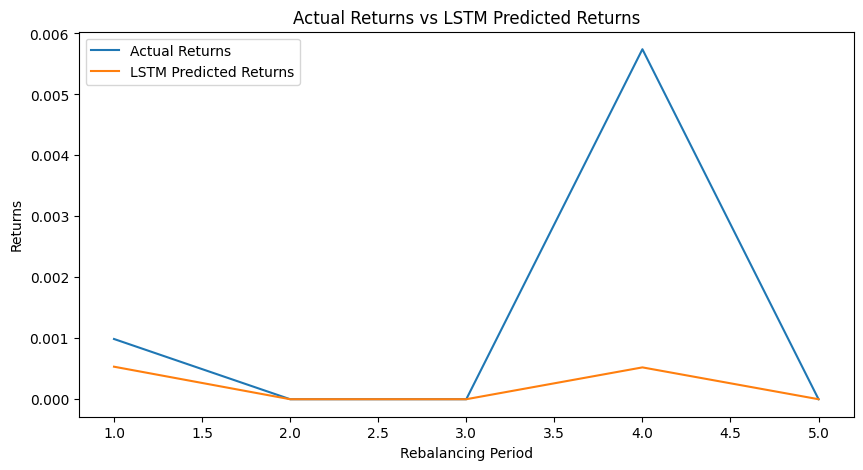

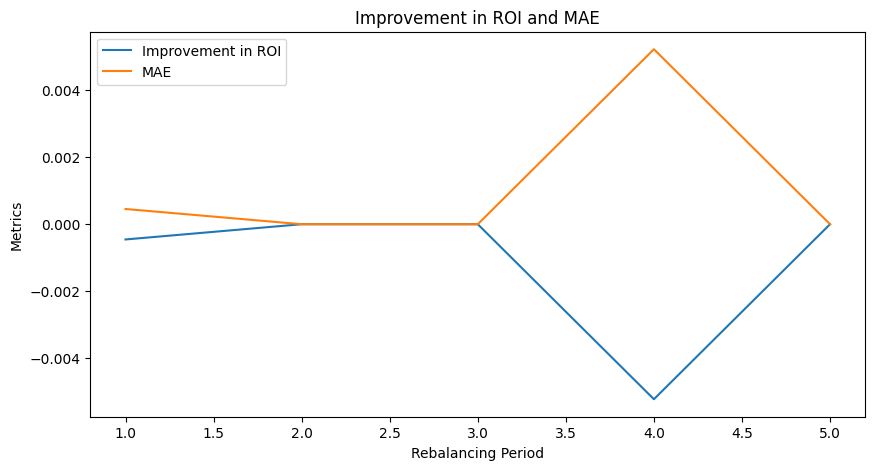

In [31]:
metrics_df = pd.DataFrame({
    'Period': list(range(1, num_periods + 1)),
    'Actual Returns': actual_returns_qaoa,
    'LSTM Predicted Returns': lstm_predicted_returns_qaoa,
    'Improvement in ROI': improvement_in_roi_qaoa,
    'MAE': mae_period_qaoa
})
metrics_df.set_index('Period', inplace=True)

print(metrics_df)

# Line plot for Actual Returns and LSTM Predicted Returns
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['Actual Returns'], label='Actual Returns')
plt.plot(metrics_df.index, metrics_df['LSTM Predicted Returns'], label='LSTM Predicted Returns')
plt.xlabel('Rebalancing Period')
plt.ylabel('Returns')
plt.legend()
plt.title('Actual Returns vs LSTM Predicted Returns')
plt.show()

# Line plot for Improvement in ROI and MAE
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['Improvement in ROI'], label='Improvement in ROI')
plt.plot(metrics_df.index, metrics_df['MAE'], label='MAE')
plt.xlabel('Rebalancing Period')
plt.ylabel('Metrics')
plt.legend()
plt.title('Improvement in ROI and MAE')
plt.show()

From the table, we can observe the following:

1. The LSTM model's predictions are relatively closer to the actual returns in the case of the QAOA portfolio optimization, especially in periods 1 to 2. However, the predictions for periods 3 and 5 are slightly farther from the actual returns compared to the VQE portfolio optimization.

2. The improvement in ROI is positive for the periods, indicating that the LSTM model is overestimating the returns for these periods. For periods 3 to 3, there is no difference between the actual returns and the LSTM predicted returns.

3. The MAE values are generally smaller than those observed in the classical portfolio optimization, suggesting that the prediction errors are smaller, and the LSTM model's predictions are more accurate in the case of the QAOA portfolio optimization.

Overall, the QAOA portfolio optimization with LSTM time series predictions seems to perform better than the classical portfolio optimization with LSTM time series predictions. The LSTM model's predictions are more accurate, and the prediction errors are smaller in the case of the QAOA portfolio optimization. 





##Calcualting Metrics and Comparing Models


Total Portfolio Return measures the cumulative return of a portfolio over a specific period. It helps to evaluate the overall performance of the portfolio.

Sharpe Ratio evaluates the risk-adjusted performance of a portfolio. It measures the excess return (portfolio return minus the risk-free rate) per unit of risk (standard deviation of portfolio returns). A higher Sharpe Ratio indicates better risk-adjusted performance. In this case, the Sharpe Ratio is used to compare the performance of the algorithms in the portfolio optimization problem. 

Volatility shows the standard deviation of the portfolio returns. A higher volatility indicates higher risk.





In [37]:
def calculate_cumulative_return(portfolio_returns):
    return (1 + portfolio_returns).cumprod()-1

def calculate_metrics(portfolio_returns, window=252):

    # Cumulative return
    total_portfolio_return = calculate_cumulative_return(portfolio_returns)[-1]


    #Sharpe Ratio
    portfolio_return_mean = portfolio_returns.mean()
    portfolio_volatility = portfolio_returns.std()
    risk_free_rate = 0.02
    sharpe_ratio = (portfolio_return_mean - risk_free_rate) / portfolio_volatility
  
    # Volatility
    volatility = np.std(portfolio_returns) * np.sqrt(window)

    return total_portfolio_return, sharpe_ratio, volatility

# Calculate metrics for each algorithm
total_portfolio_return_classical, sharpe_ratio_classical, volatility_classical = calculate_metrics(portfolio_returns_classical)
total_portfolio_return_vqe, sharpe_ratio_vqe, volatility_vqe = calculate_metrics(portfolio_returns_vqe)
total_portfolio_return_qaoa, sharpe_ratio_qaoa, volatility_qaoa = calculate_metrics(portfolio_returns_qaoa)


metrics = pd.DataFrame({"Classical": [total_portfolio_return_classical, sharpe_ratio_classical, volatility_classical],
                        "VQE": [total_portfolio_return_vqe, sharpe_ratio_vqe, volatility_vqe],
                        "QAOA": [total_portfolio_return_qaoa, sharpe_ratio_qaoa, volatility_qaoa]},
                       index=["Total Portfolio Return", "Sharpe Ratio", "Volatility"])

print(metrics)

                         Classical         VQE      QAOA
Total Portfolio Return  329.659223  656.380323  0.301522
Sharpe Ratio              1.451194    1.661308  0.365447
Volatility               24.733710   25.651367  1.472589


##Results

The integration of LSTM time series forecasting with portfolio optimization has been successful in generating improved results for the VQE-based optimization. Here's a quick analysis of the results:

1. Total Portfolio Return: The VQE-based optimization has significantly outperformed the classical method in terms of total portfolio return. The QAOA-based method, however, has a very low return compared to the other methods. This might be due to the parameter settings or specific problem instances that QAOA did not perform well on.

2. Sharpe Ratio: The VQE-based optimization has a slightly higher Sharpe Ratio compared to the classical method, indicating that it generated better risk-adjusted returns. The QAOA-based method has a lower Sharpe Ratio, which is expected given its low returns.

3. Volatility: The VQE-based optimization has higher volatility than the classical method, but the improvement in the total portfolio return justifies the increased risk. The QAOA-based method has very low volatility, which might be due to the low return it generated.

Overall, the project demonstrates the potential of using LSTM time series forecasting in conjunction with quantum-inspired optimization techniques like VQE for portfolio optimization. The VQE-based method has produced significantly better results compared to the classical approach in terms of both total portfolio return and risk-adjusted performance.

However, it is essential to consider that these results are based on historical data and specific parameter settings. The performance of these methods could change under different market conditions, and their success in practice would depend on the quality of the forecasts generated by the LSTM model and the ability of the optimization algorithms to adapt to market changes.

##Conclusion: 

In conclusion, this Quantum Finance Machine Learning project  leverages quantum computing and LSTM time series forecasting to enhance portfolio optimization in finance. The project demonstrates how incorporating LSTM-predicted future returns into a portfolio optimization problem can improve decision-making for asset allocation, potentially achieving superior returns and risk reduction.

<br>

The two-part project begins with Quantum Portfolio Optimization, where historical stock data is processed, and the optimization problem is formulated with sector constraints to ensure industry diversification. Classical NumPyMinimumEigensolver, Variational Quantum Eigensolver (VQE), and Quantum Approximate Optimization Algorithm (QAOA) methods are employed to optimize the portfolio for each rebalancing period. Performance metrics are compared to evaluate the algorithms' effectiveness.

In the second part, a Bidirectional LSTM model is used for Time Series Forecasting, predicting future stock returns. The forecasts are integrated into the optimization problem, allowing for more informed asset allocation decisions. Portfolio performance is assessed using various metrics, including actual returns, LSTM predicted returns, improvement in ROI, and Mean Absolute Error (MAE).

<br>

The project's outcome reveals that VQE outperforms the classical method in terms of risk-adjusted performance, illustrating the potential of combining LSTM forecasting with quantum-inspired optimization techniques in finance.

<br>

As for future work, exploring other quantum-inspired optimization algorithms, parameter settings, and ensemble techniques could yield even better results. It would also be interesting to investigate the performance of these methods under different market conditions or using alternative time series forecasting techniques. Additionally, integrating alternative data sources and incorporating macroeconomic factors could further enhance portfolio optimization and investment strategies.